In [21]:
!pwd
!ls -l /kaggle/input/working
!cp -r /kaggle/input/working/socialways ./
import sys
package_paths = [
    'socialways/utils/*','socialways*'
]
for pth in package_paths:
    print(pth)
    sys.path.append(pth)
from socialways.utils.parse_utils import Scale
from socialways.utils.linear_models import predict_cv

/kaggle/working
total 0
drwxr-xr-x 3 nobody nogroup 0 Sep  2 03:41 socialways
/kaggle/input/working/socialways/utils/*
/kaggle/input/working/socialways*


In [22]:
import numpy as np
from socialways.utils.parse_utils import BIWIParser, create_dataset

annot_file = 'socialways/dataset/obsmat.txt'   # FixMe: fix the input address
npz_out_file = '../data-8-12.npz'           # FixMe: fix the output filename
parser = BIWIParser()
parser.load(annot_file)

obsvs, preds, times, batches = create_dataset(parser.p_data,
                                              parser.t_data,
                                              range(parser.t_data[0][0], parser.t_data[-1][-1], parser.interval),
                                              8, 12)

np.savez(npz_out_file, obsvs=obsvs, preds=preds, times=times, batches=batches)
print('dataset was created successfully and stored in:', npz_out_file)



dataset was created successfully and stored in: ../data-8-12.npz


In [23]:
!ls -l socialways
# !rm -f socialways/socialWays-eth.pt

total 72
-rw-r--r-- 1 root root     0 Sep  2 04:59 __init__.py
drwxr-xr-x 2 root root  4096 Sep  2 03:55 __pycache__
-rw-r--r-- 1 root root  7824 Sep  2 04:59 calc_statistics.py
-rw-r--r-- 1 root root   716 Sep  2 04:59 create_dataset.py
-rw-r--r-- 1 root root  7862 Sep  2 04:59 create_toy.py
-rw-r--r-- 1 root root   447 Sep  2 04:59 pick_subset.py
-rw-r--r-- 1 root root 28186 Sep  2 04:59 train.py
drwxr-xr-x 3 root root  4096 Sep  2 03:55 utils
-rw-r--r-- 1 root root  9199 Sep  2 04:59 visualize.py


In [24]:
!pip install wandb
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [25]:
import sys

import os
import time
import argparse
import matplotlib.pyplot as plt
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.optim as opt
from tqdm import tqdm, trange
from itertools import chain
from torch.autograd import Variable
from torch.utils.data import DataLoader
#colab
# from utils.parse_utils import Scale
# from utils.linear_models import predict_cv

wandb.init(project='socialways-test')
config = wandb.config
config.batch_size = 256
config.test_batch_size = 256
config.epochs = 500
config.lr = 1E-4
config.log_interval = 10

# Parser arguments
parser = argparse.ArgumentParser(description='Social Ways trajectory prediction.')
#parser.add_argument('-f', '')
parser.add_argument('--batch-size', '--b',
                    type=int, default=256, metavar='N',
                    help='input batch size for training (default: 256)')
parser.add_argument('--epochs', '--e',
                    type=int, default=500, metavar='N',
                    help='number of epochs to train (default: 1000)')
parser.add_argument('--model', '--m',
                    default='socialWays',
                    choices=['socialWays'],
                    help='pick a specific network to train'
                         '(default: "socialWays")')
parser.add_argument('--latent-dim', '--ld',
                    type=int, default=10, metavar='N',
                    help='dimension of latent space (default: 10)')
parser.add_argument('--d-learning-rate', '--d-lr',
                    type=float, default=1E-3, metavar='N',
                    help='learning rate of discriminator (default: 1E-3)')
parser.add_argument('--g-learning-rate', '--g-lr',
                    type=float, default=1E-4, metavar='N',
                    help='learning rate of generator (default: 1E-4)')
parser.add_argument('--unrolling-steps', '--unroll',
                    type=int, default=1, metavar='N',
                    help='number of steps to unroll gan (default: 1)')
parser.add_argument('--hidden-size', '--h-size',
                    type=int, default=64, metavar='N',
                    help='size of network intermediate layer (default: 64)')
parser.add_argument('--dataset', '--data',
                    default='data-8-12',
                    choices=['data-8-12'],
                    help='pick a specific dataset (default: "hotel")')
#args = parser.parse_args()
args, unknown = parser.parse_known_args()


# ========== set input/output files ============
dataset_name = args.dataset
model_name = args.model
# input_file = '../hotel-8-12.npz'
#input_file = 'traj-datasets/seq_eth/eth-8-12.npz'
#model_file = '../trained_models/' + model_name + '-' + dataset_name + '.pt'
# colab
# input_file = '/content/drive/Othercomputers/My MacBook Pro/projs/socialways/traj-datasets/data_zara02/zara02-8-12.npz'
# model_file = '/content/drive/Othercomputers/My MacBook Pro/projs/socialways/' + model_name + '-' + dataset_name + '.pt'
# kaggle
input_file = '../data-8-12.npz'
model_file = 'socialways/' + model_name + '-' + dataset_name + '.pt'

# FIXME: ====== training hyper-parameters ======
# Unrolled GAN
n_unrolling_steps = args.unrolling_steps
# Info GAN
use_info_loss = True
n_latent_codes = 2
# L2 GAN
use_l2_loss = False
use_variety_loss = False
loss_l2_w = 0.5  # WARNING for both l2 and variety
# Learning Rate
lr_g = args.g_learning_rate
lr_d = args.d_learning_rate
# FIXME: ====== Network Size ===================
# Batch size
batch_size = args.batch_size
# LSTM hidden size
hidden_size = args.hidden_size
n_epochs = args.epochs
num_social_features = 3
social_feature_size = args.hidden_size
noise_len = args.hidden_size // 2
n_lstm_layers = 1
use_social = False
# ==============================================

# FIXME: ======= Loda Data =====================
# print(os.path.dirname(os.path.realpath(__file__)))

data = np.load(input_file)
# Data come as NxTx2 numpy nd-arrays where N is the number of trajectories,
# T is their duration.
dataset_obsv, dataset_pred, dataset_t, the_batches = \
    data['obsvs'], data['preds'], data['times'], data['batches']
# 4/5 of the batches to be used for training
train_size = max(1, (len(the_batches) * 4) // 5)
train_batches = the_batches[:train_size]
# Test batches are the remaining ones
test_batches = the_batches[train_size:]
# Size of the observed sub-paths
n_past = dataset_obsv.shape[1]
# Size of the sub-paths to predict
n_next = dataset_pred.shape[1]
# Number of training samples
n_train_samples = the_batches[train_size - 1][1]
# Number of testing samples (the remaining ones)
n_test_samples = dataset_obsv.shape[0] - n_train_samples
if n_test_samples == 0:
    n_test_samples = 1
    the_batches = np.array([the_batches[0], the_batches[0]])
print(input_file, ' # Training samples: ', n_train_samples)

# Normalize the spatial data
scale = Scale()
scale.max_x = max(np.max(dataset_obsv[:, :, 0]), np.max(dataset_pred[:, :, 0]))
scale.min_x = min(np.min(dataset_obsv[:, :, 0]), np.min(dataset_pred[:, :, 0]))
scale.max_y = max(np.max(dataset_obsv[:, :, 1]), np.max(dataset_pred[:, :, 1]))
scale.min_y = min(np.min(dataset_obsv[:, :, 1]), np.min(dataset_pred[:, :, 1]))
scale.calc_scale(keep_ratio=True)
dataset_obsv = scale.normalize(dataset_obsv)
dataset_pred = scale.normalize(dataset_pred)
ss = scale.sx
# Copy normalized observations/paths to predict into torch GPU tensors
dataset_obsv = torch.FloatTensor(dataset_obsv).cuda()
dataset_pred = torch.FloatTensor(dataset_pred).cuda()


# ================================================

# Augment tensors of positions into positions+velocity
def get_traj_4d(obsv_p, pred_p):
    obsv_v = obsv_p[:, 1:] - obsv_p[:, :-1]
    obsv_v = torch.cat([obsv_v[:, 0].unsqueeze(1), obsv_v], dim=1)
    obsv_4d = torch.cat([obsv_p, obsv_v], dim=2)
    if len(pred_p) == 0: return obsv_4d
    pred_p_1 = torch.cat([obsv_p[:, -1].unsqueeze(1), pred_p[:, :-1]], dim=1)
    pred_v = pred_p - pred_p_1
    pred_4d = torch.cat([pred_p, pred_v], dim=2)
    return obsv_4d, pred_4d


# Evaluate the error between the model prediction and the true path
def calc_error(pred_hat, pred):
    N = pred.size(0)
    T = pred.size(1)
    err_all = torch.pow((pred_hat - pred) / ss, 2).sum(dim=2).sqrt()  # N x T
    FDEs = err_all.sum(dim=0).item() / N
    ADEs = torch.cumsum(FDEs)
    for ii in range(T):
        ADEs[ii] /= (ii + 1)
    return ADEs.data.cpu().numpy(), FDEs.data().cpu().numpy()


class AttentionPooling(nn.Module):
    def __init__(self, h_dim, f_dim):
        super(AttentionPooling, self).__init__()
        self.f_dim = f_dim
        self.h_dim = h_dim
        self.W = nn.Linear(h_dim, f_dim, bias=True)

    def forward(self, f, h, sub_batches):
        Wh = self.W(h)
        S = torch.zeros_like(h)
        for sb in sub_batches:
            N = sb[1] - sb[0]
            if N == 1: continue

            for ii in range(sb[0], sb[1]):
                fi = f[ii, sb[0]:sb[1]]
                sigma_i = torch.bmm(fi.unsqueeze(1), Wh[sb[0]:sb[1]]. unsqueeze(2))
                sigma_i[ii-sb[0]] = -1000

                attentions = torch.softmax(sigma_i.squeeze(), dim=0)
                S[ii] = torch.mm(attentions.view(1, N), h[sb[0]:sb[1]])

        return S


class EmbedSocialFeatures(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EmbedSocialFeatures, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc = nn.Sequential(nn.Linear(input_size, 32), nn.ReLU(),
                                nn.Linear(32, 64), nn.ReLU(),
                                nn.Linear(64, hidden_size))

    def forward(self, ftr_list, sub_batches):
        embedded_features = self.fc(ftr_list)
        return embedded_features


def DCA(xA_4d, xB_4d):
    dp = xA_4d[:2] - xB_4d[:2]
    dv = xA_4d[2:] - xB_4d[2:]
    ttca = torch.dot(-dp, dv) / (torch.norm(dv) ** 2 + 1E-6)
    # ttca = torch.max(ttca, 0)
    dca = torch.norm(dp + ttca * dv)
    return dca


def Bearing(xA_4d, xB_4d):
    dp = xA_4d[:2] - xB_4d[:2]
    v = xA_4d[2:]
    cos_theta = torch.dot(dp, v) / (torch.norm(dp) * torch.norm(v) + 1E-6)
    return cos_theta


def DCA_MTX(x_4d, D_4d):
    Dp = D_4d[:, :, :2]
    Dv = D_4d[:, :, 2:]
    DOT_Dp_Dv = torch.mul(Dp[:,:,0], Dv[:,:,0]) + torch.mul(Dp[:,:,1], Dv[:,:,1])
    Dv_sq = torch.mul(Dv[:,:,0], Dv[:,:,0]) + torch.mul(Dv[:,:,1], Dv[:,:,1]) + 1E-6
    TTCA = -torch.div(DOT_Dp_Dv, Dv_sq)
    DCA = torch.zeros_like(Dp)
    DCA[:, :, 0] = Dp[:, :, 0] + TTCA * Dv[:, :, 0]
    DCA[:, :, 1] = Dp[:, :, 1] + TTCA * Dv[:, :, 1]
    DCA = torch.norm(DCA, dim=2)
    return DCA


def BearingMTX(x_4d, D_4d):
    Dp = D_4d[:, :, :2]  # NxNx2
    v = x_4d[:, 2:].unsqueeze(1).repeat(1, x_4d.shape[0], 1)  # => NxNx2
    DOT_Dp_v = Dp[:, :, 0] * v[:, :, 0] + Dp[:, :, 1] * v[:, :, 1]
    COS_THETA = torch.div(DOT_Dp_v, torch.norm(Dp, dim=2) * torch.norm(v, dim=2) + 1E-6)
    return COS_THETA


def SocialFeatures(x, sub_batches):
    N = x.shape[0]  # x is NxTx4 tensor

    x_ver_repeat = x[:, -1].unsqueeze(0).repeat(N, 1, 1)
    x_hor_repeat = x[:, -1].unsqueeze(1).repeat(1, N, 1)
    Dx_mat = x_hor_repeat - x_ver_repeat

    l2_dist_MTX = Dx_mat[:, :, :2].norm(dim=2)
    bearings_MTX = BearingMTX(x[:, -1], Dx_mat)
    dcas_MTX = DCA_MTX(x[:, -1], Dx_mat)
    sFeatures_MTX = torch.stack([l2_dist_MTX, bearings_MTX, dcas_MTX], dim=2)

    return sFeatures_MTX   # directly return the Social Features Matrix


# LSTM path encoding module
class EncoderLstm(nn.Module):
    def __init__(self, hidden_size, n_layers=2):
        # Dimension of the hidden state (h)
        self.hidden_size = hidden_size
        super(EncoderLstm, self).__init__()
        # Linear embedding 4xh
        self.embed = nn.Linear(4, self.hidden_size)
        # The LSTM cell.
        # Input dimension (observations mapped through embedding) is the same as the output
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=n_layers, batch_first=True)
        self.lstm_h = []
        # init_weights(self)

    def init_lstm(self, h, c):
        # Initialization of the LSTM: hidden state and cell state
        self.lstm_h = (h, c)

    def forward(self, obsv):
        # Batch size
        bs = obsv.shape[0]
        # Linear embedding
        obsv = self.embed(obsv)
        # Reshape and applies LSTM over a whole sequence or over one single step
        y, self.lstm_h = self.lstm(obsv.view(bs, -1, self.hidden_size), self.lstm_h)
        return y


class Discriminator(nn.Module):
    def __init__(self, n_next, hidden_dim, n_latent_code):
        super(Discriminator, self).__init__()
        self.lstm_dim = hidden_dim
        self.n_next = n_next
        # LSTM Encoder for the observed part
        self.obsv_encoder_lstm = nn.LSTM(4, hidden_dim, batch_first=True)
        # FC sub-network: input is hidden_dim, output is hidden_dim//2. This ouput will be part of
        # the input of the classifier.
        self.obsv_encoder_fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim // 2), nn.LeakyReLU(0.2),
                                             nn.Linear(hidden_dim // 2, hidden_dim // 2))
        # FC Encoder for the predicted part: input is n_next*4 (whole predicted trajectory), output is
        # hidden_dim//2. This ouput will also be part of the input of the classifier.
        self.pred_encoder = nn.Sequential(nn.Linear(n_next * 4, hidden_dim // 2), nn.LeakyReLU(0.2),
                                          nn.Linear(hidden_dim // 2, hidden_dim // 2))
        # Classifier: input is hidden_dim (concatenated encodings of observed and predicted trajectories), output is 1
        self.classifier = nn.Sequential(nn.Linear(hidden_dim, hidden_dim // 2), nn.LeakyReLU(0.2),
                                        nn.Linear(hidden_dim // 2, 1))
        # Latent code inference: input is hidden_dim (concatenated encodings of observed and predicted trajectories), output is n_latent_code (distribution of latent codes)
        self.latent_decoder = nn.Sequential(nn.Linear(hidden_dim, hidden_dim // 2), nn.LeakyReLU(0.2),
                                            nn.Linear(self.lstm_dim // 2, n_latent_code))

    def forward(self, obsv, pred):
        bs = obsv.size(0)
        lstm_h_c = (torch.zeros(1, bs, self.lstm_dim).cuda(),
                    torch.zeros(1, bs, self.lstm_dim).cuda())
        # Encoding of the observed sequence trhough an LSTM cell
        obsv_code, lstm_h_c = self.obsv_encoder_lstm(obsv, lstm_h_c)
        # Further encoding through a FC layer
        obsv_code = self.obsv_encoder_fc(obsv_code[:, -1])
        # Encoding of the predicted/next part of the sequence through a FC layer
        pred_code = self.pred_encoder(pred.view(-1, self.n_next * 4))
        both_codes = torch.cat([obsv_code, pred_code], dim=1)
        # Applies classifier to the concatenation of the encodings of both parts
        label = self.classifier(both_codes)
        # Inference on the latent code
        code_hat = self.latent_decoder(both_codes)
        return label, code_hat

    def load(self, backup):
        for m_from, m_to in zip(backup.modules(), self.modules()):
            if isinstance(m_to, nn.Linear):
                m_to.weight.data = m_from.weight.data.clone()
                if m_to.bias is not None:
                    m_to.bias.data = m_from.bias.data.clone()


# FC path decoding module
class DecoderFC(nn.Module):
    def __init__(self, hidden_dim):
        super(DecoderFC, self).__init__()
        # Fully connected sub-network. Input is hidden_dim, output is 2.
        self.fc1 = torch.nn.Sequential(torch.nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(0.2),
                                       # torch.nn.Linear(64, 64), nn.LeakyReLU(0.2),
                                       torch.nn.Linear(hidden_dim, hidden_dim // 2), nn.LeakyReLU(0.2),
                                       torch.nn.Linear(hidden_dim // 2, hidden_dim // 4),
                                       torch.nn.Linear(hidden_dim // 4, 2))

    def forward(self, h, s, z):
        # For each sample in the batch, concatenate h (hidden state), s (social term) and z (noise)
        inp = torch.cat([h, s, z], dim=1)
        # Applies the fully connected layer
        out = self.fc1(inp)
        return out


# LSTM path decoding module
class DecoderLstm(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DecoderLstm, self).__init__()
        # Decoding LSTM
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        # Fully connected sub-network. Input is hidden_size, output is 2.
        self.fc = nn.Sequential(torch.nn.Linear(hidden_size, 64), nn.Sigmoid(),
                                torch.nn.Linear(64, 64), nn.LeakyReLU(0.2),
                                torch.nn.Linear(64, 32), nn.LeakyReLU(0.2),
                                torch.nn.Linear(32, 2))

        # init_weights(self)
        self.lstm_h = []

    def init_lstm(self, h, c):
        # Initialization of the LSTM: hidden state and cell state
        self.lstm_h = (h, c)

    def forward(self, h, s, z):
        # Batch size
        bs = z.shape[0]
        # For each sample in the batch, concatenate h (hidden state), s (social term) and z (noise)
        inp = torch.cat([h, s, z], dim=1)
        # Applies a forward step.
        out, self.lstm_h = self.lstm(inp.unsqueeze(1), self.lstm_h)
        # Applies the fully connected layer to the LSTM output
        out = self.fc(out.squeeze())
        return out


# LSTM-based path encoder
encoder = EncoderLstm(hidden_size, n_lstm_layers).cuda()
feature_embedder = EmbedSocialFeatures(num_social_features, social_feature_size).cuda()
attention = AttentionPooling(hidden_size, social_feature_size).cuda()

# Decoder
decoder = DecoderFC(hidden_size + social_feature_size + noise_len).cuda()
# decoder = DecoderLstm(social_feature_size + VEL_VEC_LEN + noise_len, traj_code_len).cuda()

# The Generator parameters and their optimizer
predictor_params = chain(attention.parameters(), feature_embedder.parameters(),
                         encoder.parameters(), decoder.parameters())
predictor_optimizer = opt.Adam(predictor_params, lr=lr_g, betas=(0.9, 0.999))

# The Discriminator parameters and their optimizer
D = Discriminator(n_next, hidden_size, n_latent_codes).cuda()
D_optimizer = opt.Adam(D.parameters(), lr=lr_d, betas=(0.9, 0.999))
mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss()

print('hidden dim = %d | lr(G) =  %.5f | lr(D) =  %.5f' % (hidden_size, lr_g, lr_d))


def predict(obsv_p, noise, n_next, sub_batches=[]):
    # Batch size
    bs = obsv_p.shape[0]
    # Adds the velocity component to the observations.
    # This makes of obsv_4d a batch_sizexTx4 tensor
    obsv_4d = get_traj_4d(obsv_p, [])
    # Initial values for the hidden and cell states (zero)
    lstm_h_c = (torch.zeros(n_lstm_layers, bs, encoder.hidden_size).cuda(),
                torch.zeros(n_lstm_layers, bs, encoder.hidden_size).cuda())
    encoder.init_lstm(lstm_h_c[0], lstm_h_c[1])
    # Apply the encoder to the observed sequence
    # obsv_4d: batch_sizexTx4 tensor
    encoder(obsv_4d)
    if len(sub_batches) == 0:
        sub_batches = [[0, obsv_p.size(0)]]

    if use_social:
        features = SocialFeatures(obsv_4d, sub_batches)
        emb_features = feature_embedder(features, sub_batches)
        weighted_features = attention(emb_features, encoder.lstm_h[0].squeeze(), sub_batches)
    else:
        weighted_features = torch.zeros_like(encoder.lstm_h[0].squeeze())

    pred_4ds = []
    last_obsv = obsv_4d[:, -1]
    # For all the steps to predict, applies a step of the decoder
    for ii in range(n_next):
        # Takes the current output of the encoder to feed the decoder
        # Gets the ouputs as a displacement/velocity
        new_v = decoder(encoder.lstm_h[0].view(bs, -1), weighted_features.view(bs, -1), noise).view(bs, 2)
        # Deduces the predicted position
        new_p = new_v + last_obsv[:, :2]
        # The last prediction done will be new_p,new_v
        last_obsv = torch.cat([new_p, new_v], dim=1)
        # Keeps all the predictions
        pred_4ds.append(last_obsv)
        # Applies LSTM encoding to the last prediction
        # pred_4ds[-1]: batch_sizex4 tensor
        encoder(pred_4ds[-1])

    return torch.stack(pred_4ds, 1)


# ===================================================


# =============== Training Loop ==================
def train():
    tic = time.clock()
    # Evaluation metrics (ADE/FDE)
    train_ADE, train_FDE = 0, 0
    avg_G_INFO_LOSS = 0
    avg_D_INFO_LOSS = 0
    batch_size_accum = 0
    sub_batches = []
    # For all the training batches
    for ii, batch_i in enumerate(train_batches):
        batch_size_accum += batch_i[1] - batch_i[0]
        sub_batches.append(batch_i)

        # FIXME: Just keep it for toy dataset
        # sub_batches = the_batches
        # batch_size_accum = sub_batches[-1][1]
        # ii = train_size-1

        if ii >= train_size - 1 or \
                batch_size_accum + (the_batches[ii + 1][1] - the_batches[ii + 1][0]) > batch_size:
            # Observed partial paths
            obsv = dataset_obsv[sub_batches[0][0]:sub_batches[-1][1]]
            # Future partial paths
            pred = dataset_pred[sub_batches[0][0]:sub_batches[-1][1]]
            sub_batches = sub_batches - sub_batches[0][0]
            # May have to fill with 0
            filling_len = batch_size - int(batch_size_accum)
            #obsv = torch.cat((obsv, torch.zeros(filling_len, n_past, 2).cuda()), dim=0)
            #pred = torch.cat((pred, torch.zeros(filling_len, n_next, 2).cuda()), dim=0)

            bs = batch_size_accum

            # Completes the positional vectors with velocities (to have dimension 4)
            obsv_4d, pred_4d = get_traj_4d(obsv, pred)
            zeros = Variable(torch.zeros(bs, 1) + np.random.uniform(0, 0.1), requires_grad=False).cuda()
            ones = Variable(torch.ones(bs, 1) * np.random.uniform(0.9, 1.0), requires_grad=False).cuda()
            noise = torch.FloatTensor(torch.rand(bs, noise_len)).cuda()
            # noise = torch.IntTensor(torch.randint(bs, noise_len)).cude()
            # print("noise=", noise.shape, "\t", noise)

            # ============== Train Discriminator ================
            for u in range(n_unrolling_steps + 1):
                # Zero the gradient buffers of all parameters
                D.zero_grad()
                with torch.no_grad():
                    pred_hat_4d = predict(obsv, noise, n_next, sub_batches)

                fake_labels, code_hat = D(obsv_4d, pred_hat_4d)  # classify fake samples
                # Evaluate the MSE loss: the fake_labels should be close to zero
                d_loss_fake = mse_loss(fake_labels, zeros)
                d_loss_info = mse_loss(code_hat.squeeze(), noise[:, :n_latent_codes])
                #avg_D_INFO_LOSS += d_loss_info * loss_info_w
                avg_D_INFO_LOSS += d_loss_info
                # Evaluate the MSE loss: the real should be close to one
                real_labels, code_hat = D(obsv_4d, pred_4d)  # classify real samples
                d_loss_real = mse_loss(real_labels, ones)

                #  FIXME: which loss functinos to use for D?
                d_loss = d_loss_fake + d_loss_real
                if use_info_loss:
                    #
                    d_loss += loss_info_w * d_loss_info
                d_loss.backward()  # update D
                D_optimizer.step()

                if u == 0 and n_unrolling_steps > 0:
                    backup = copy.deepcopy(D)

            # =============== Train Generator ================= #
            # Zero the gradient buffers of all the discriminator parameters
            D.zero_grad()
            # Zero the gradient buffers of all the generator parameters
            predictor_optimizer.zero_grad()
            # Applies a forward step of prediction
            pred_hat_4d = predict(obsv, noise, n_next, sub_batches)

            # Classify the generated fake sample
            gen_labels, code_hat = D(obsv_4d, pred_hat_4d)
            # L2 loss between the predicted paths and the true ones
            g_loss_l2 = mse_loss(pred_hat_4d[:, :, :2], pred)
            # Adversarial loss (classification labels should be close to one)
            g_loss_fooling = mse_loss(gen_labels, ones)
            # Information loss
            g_loss_info = mse_loss(code_hat.squeeze(), noise[:, :n_latent_codes])
            avg_G_INFO_LOSS += loss_info_w * g_loss_info
            #  FIXME: which loss functions to use for G?
            #
            g_loss = g_loss_fooling
            # If using the info loss
            if use_info_loss:
                g_loss += loss_info_w * g_loss_info
            # If using the L2 loss
            if use_l2_loss:
                g_loss += loss_l2_w * g_loss_l2
            if use_variety_loss:
                KV = 20
                all_20_losses = []
                for k in range(KV):
                    pred_hat_4d = predict(obsv, noise, n_next, sub_batches)
                    loss_l2_k = mse_loss(pred_hat_4d[k, :, :2], pred[k])
                all_20_losses.append(loss_l2_k.unsqueeze(0))
                all_20_losses = torch.cat(all_20_losses)
                variety_loss, _ = torch.min(all_20_losses, dim=0)
                g_loss += loss_l2_w * variety_loss

            g_loss.backward()
            predictor_optimizer.step()

            if n_unrolling_steps > 0:
                D.load(backup)
                del backup

            # calculate error
            with torch.no_grad():  # TODO: use the function above
                err_all = torch.pow((pred_hat_4d[:, :, :2] - pred) / ss, 2)
                err_all = err_all.sum(dim=2).sqrt()
                e = err_all.sum().item() / n_next
                train_ADE += e
                train_FDE += err_all[:, -1].sum().item()

            batch_size_accum = 0;
            sub_batches = []

    # print('train, cnt=', cnt, ', g_info_cnt=', g_info_cnt, ', d_info_cnt=', d_info_cnt)
    train_ADE /= n_train_samples
    train_FDE /= n_train_samples
    avg_G_INFO_LOSS /= n_train_samples
    avg_D_INFO_LOSS /= n_train_samples
    toc = time.clock()
    # print("codes= ", code_hat)
    wandb.log({
        "ADE": train_ADE,
        "FDE": train_FDE,
        "avg_G_INFO_LOSS": avg_G_INFO_LOSS,
        "avg_D_INFO_LOSS": avg_D_INFO_LOSS,
        "g_loss": g_loss,
        "d_loss": d_loss,
        "g_info_loss": loss_info_w * g_loss_info,
        "d_info_loss": loss_info_w * d_loss_info
    })
    print(" Epc=%4d, Train ADE,FDE = (%.3f, %.3f), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(%.3f, %.3f) | time = %.1f" \
          % (epoch, train_ADE, train_FDE, avg_G_INFO_LOSS, avg_D_INFO_LOSS, toc - tic))


def test(n_gen_samples=20, linear=False, write_to_file=None, just_one=True):
    # =========== Test error ============
    plt.close()
    ade_avg_12, fde_avg_12 = 0, 0
    ade_min_12, fde_min_12 = 0, 0
    for ii, batch_i in enumerate(test_batches):
        obsv = dataset_obsv[batch_i[0]:batch_i[1]]
        pred = dataset_pred[batch_i[0]:batch_i[1]]
        current_t = dataset_t[batch_i[0]]
        bs = int(batch_i[1] - batch_i[0])
        with torch.no_grad():
            all_20_errors = []
            all_20_preds = []

            linear_preds = predict_cv(obsv, n_next)
            if linear and not write_to_file:
                all_20_preds.append(linear_preds.unsqueeze(0))
                err_all = torch.pow((linear_preds[:, :, :2] - pred) / ss, 2).sum(dim=2, keepdim=True).sqrt()
                all_20_errors.append(err_all.unsqueeze(0))
            else:
                for kk in range(n_gen_samples):
                    noise = torch.FloatTensor(torch.rand(bs, noise_len)).cuda()
                    pred_hat_4d = predict(obsv, noise, n_next)
                    all_20_preds.append(pred_hat_4d.unsqueeze(0))
                    err_all = torch.pow((pred_hat_4d[:, :, :2] - pred) / ss, 2).sum(dim=2, keepdim=True).sqrt()
                    all_20_errors.append(err_all.unsqueeze(0))

            all_20_errors = torch.cat(all_20_errors)
            if write_to_file:
                # file_name = os.path.join(write_to_file, str(epoch) + '-' + str(current_t) + '.npz')
                file_name = os.path.join(write_to_file, str(ii) + '-' + str(current_t) + '.npz')
                print('saving to ', file_name)
                np_obsvs = scale.denormalize(obsv[:, :, :2].data.cpu().numpy())
                np_preds_our = scale.denormalize(torch.cat(all_20_preds)[:, :, :, :2].data.cpu().numpy())
                np_preds_gtt = scale.denormalize(pred[:, :, :2].data.cpu().numpy())
                np_preds_lnr = scale.denormalize(linear_preds[:, :, :2].data.cpu().numpy())
                np.savez(file_name, timestamp=current_t,
                         obsvs=np_obsvs, preds_our=np_preds_our, preds_gtt=np_preds_gtt, preds_lnr=np_preds_lnr)

            # =============== Prediction Errors ================
            fde_min_12_i, _ = all_20_errors[:, :, -1].min(0, keepdim=True)
            ade_min_12_i, _ = all_20_errors.mean(2).min(0, keepdim=True)
            fde_min_12 += fde_min_12_i.sum().item()
            ade_min_12 += ade_min_12_i.sum().item()
            fde_avg_12 += all_20_errors[:, :, -1].mean(0, keepdim=True).sum().item()
            ade_avg_12 += all_20_errors.mean(2).mean(0, keepdim=True).sum().item()
            # ==================================================
        if just_one: break

    ade_avg_12 /= n_test_samples
    fde_avg_12 /= n_test_samples
    ade_min_12 /= n_test_samples
    fde_min_12 /= n_test_samples
    print('Avg ADE,FDE (12)= (%.3f, %.3f) | Min(20) ADE,FDE (12)= (%.3f, %.3f)' \
          % (ade_avg_12, fde_avg_12, ade_min_12, fde_min_12))


# =======================================================
# ===================== M A I N =========================
# =======================================================
if os.path.isfile(model_file):
    print('Loading model from ' + model_file)
    checkpoint = torch.load(model_file)
    start_epoch = checkpoint['epoch'] + 1

    attention.load_state_dict(checkpoint['attentioner_dict'])
    feature_embedder.load_state_dict(checkpoint['feature_embedder_dict'])
    encoder.load_state_dict(checkpoint['encoder_dict'])
    decoder.load_state_dict(checkpoint['decoder_dict'])
    predictor_optimizer.load_state_dict(checkpoint['pred_optimizer'])

    D.load_state_dict(checkpoint['D_dict'])
    D_optimizer.load_state_dict(checkpoint['D_optimizer'])
else:
    min_train_ADE = 10
    start_epoch = 1

# FIXME: comment here to train
# wr_dir = '/content/drive/Othercomputers/My MacBook Pro/projs/socialways/preds-iccv/' + dataset_name + '/' + model_name + '/' + str(0000)
# os.makedirs(wr_dir, exist_ok=True)
# test(n_gen_samples=128, write_to_file=wr_dir)
# exit(1)

# ===================== TRAIN =========================
for epoch in trange(start_epoch, n_epochs + 1):  # FIXME : set the number of epochs
    # Main training function
    train()

    # ============== Save model on disk ===============
    if epoch % 10 == 0:  # FIXME : set the interval for running tests
        kaggle_model_file = 'socialways/' + model_name + '-' + dataset_name + '.pt'
        print('Saving model to file ...', kaggle_model_file)
        torch.save({
            'epoch': epoch,
            'attentioner_dict': attention.state_dict(),
            'feature_embedder_dict': feature_embedder.state_dict(),
            'encoder_dict': encoder.state_dict(),
            'decoder_dict': decoder.state_dict(),
            'pred_optimizer': predictor_optimizer.state_dict(),

            'D_dict': D.state_dict(),
            'D_optimizer': D_optimizer.state_dict()
        }, kaggle_model_file)

    if epoch % 10 == 0:
        # colab
        # wr_dir = '/content/drive/Othercomputers/My MacBook Pro/projs/socialways/medium/' + dataset_name + '/' + model_name + '/' + str(epoch)
        # kaggle
        wr_dir = 'socialways/medium/' + dataset_name + '/' + model_name + '/' + str(epoch)
        os.makedirs(wr_dir, exist_ok=True)
        test(128, write_to_file=False, just_one=False)
wandb.finish()

ADE,▁▂▄▅▇███▆▅
FDE,▁▂▄▅▇███▆▅
avg_D_INFO_LOSS,█▅▃▁▁▁▁▁▁▁
avg_G_INFO_LOSS,█▅▂▁▁▁▁▁▁▁
d_info_loss,█▅▂▁▂▁▁▂▁▁
d_loss,█▆▅▄▄▃▂▁▁▁
g_info_loss,█▅▂▁▂▁▁▂▁▂
g_loss,█▅▂▁▂▃▃▄▄▅
ADE,12.5032
FDE,23.3262
avg_D_INFO_LOSS,0.00078


wandb: wandb version 0.15.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


../data-8-12.npz  # Training samples:  885
hidden dim = 64 | lr(G) =  0.00010 | lr(D) =  0.00100


  0%|          | 0/500 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:458: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:585: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  0%|          | 1/500 [00:00<02:25,  3.43it/s]

 Epc=   1, Train ADE,FDE = (9.304, 17.142), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.001, 0.002) | time = 0.3


  1%|          | 3/500 [00:00<01:52,  4.40it/s]

 Epc=   2, Train ADE,FDE = (11.422, 21.054), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.001, 0.002) | time = 0.2
 Epc=   3, Train ADE,FDE = (13.380, 24.681), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.001, 0.001) | time = 0.2


  1%|          | 5/500 [00:01<01:43,  4.80it/s]

 Epc=   4, Train ADE,FDE = (15.336, 28.332), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=   5, Train ADE,FDE = (16.529, 30.579), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  1%|          | 6/500 [00:01<01:40,  4.92it/s]

 Epc=   6, Train ADE,FDE = (16.533, 30.601), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  1%|▏         | 7/500 [00:01<01:51,  4.41it/s]

 Epc=   7, Train ADE,FDE = (15.398, 28.489), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  2%|▏         | 8/500 [00:01<01:55,  4.27it/s]

 Epc=   8, Train ADE,FDE = (13.578, 25.096), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  2%|▏         | 9/500 [00:02<01:50,  4.44it/s]

 Epc=   9, Train ADE,FDE = (11.410, 21.068), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  10, Train ADE,FDE = (9.098, 16.775), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


  2%|▏         | 11/500 [01:10<2:00:31, 14.79s/it]

Avg ADE,FDE (12)= (7.489, 13.780) | Min(20) ADE,FDE (12)= (5.983, 11.001)
 Epc=  11, Train ADE,FDE = (6.664, 12.265), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  3%|▎         | 13/500 [01:10<59:01,  7.27s/it]  

 Epc=  12, Train ADE,FDE = (4.311, 7.923), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  13, Train ADE,FDE = (3.145, 5.818), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  3%|▎         | 14/500 [01:11<41:34,  5.13s/it]

 Epc=  14, Train ADE,FDE = (4.476, 8.345), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  15, Train ADE,FDE = (7.046, 13.091), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  3%|▎         | 17/500 [01:11<15:08,  1.88s/it]

 Epc=  16, Train ADE,FDE = (9.991, 18.505), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  17, Train ADE,FDE = (12.637, 23.373), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  4%|▍         | 19/500 [01:12<08:14,  1.03s/it]

 Epc=  18, Train ADE,FDE = (15.115, 27.944), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  19, Train ADE,FDE = (17.080, 31.573), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  20, Train ADE,FDE = (18.424, 34.058), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


  4%|▍         | 21/500 [02:20<1:58:34, 14.85s/it]

Avg ADE,FDE (12)= (19.448, 35.926) | Min(20) ADE,FDE (12)= (14.455, 26.726)
 Epc=  21, Train ADE,FDE = (19.069, 35.208), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  5%|▍         | 23/500 [02:20<58:38,  7.38s/it]  

 Epc=  22, Train ADE,FDE = (18.334, 33.760), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  23, Train ADE,FDE = (16.572, 30.416), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  5%|▌         | 25/500 [02:21<29:22,  3.71s/it]

 Epc=  24, Train ADE,FDE = (13.597, 24.881), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  25, Train ADE,FDE = (10.174, 18.589), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  5%|▌         | 26/500 [02:21<20:58,  2.66s/it]

 Epc=  26, Train ADE,FDE = (6.597, 12.047), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  5%|▌         | 27/500 [02:21<15:08,  1.92s/it]

 Epc=  27, Train ADE,FDE = (3.446, 6.300), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  6%|▌         | 28/500 [02:21<11:03,  1.41s/it]

 Epc=  28, Train ADE,FDE = (1.739, 3.181), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  6%|▌         | 29/500 [02:21<08:16,  1.05s/it]

 Epc=  29, Train ADE,FDE = (2.875, 5.280), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  30, Train ADE,FDE = (4.359, 8.017), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


  6%|▌         | 31/500 [03:30<1:56:09, 14.86s/it]

Avg ADE,FDE (12)= (5.055, 9.304) | Min(20) ADE,FDE (12)= (3.792, 6.977)
 Epc=  31, Train ADE,FDE = (5.499, 10.119), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  7%|▋         | 33/500 [03:30<57:25,  7.38s/it]  

 Epc=  32, Train ADE,FDE = (6.264, 11.532), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  33, Train ADE,FDE = (6.736, 12.408), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  7%|▋         | 35/500 [03:30<28:46,  3.71s/it]

 Epc=  34, Train ADE,FDE = (6.981, 12.862), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  35, Train ADE,FDE = (6.923, 12.756), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  7%|▋         | 37/500 [03:31<14:47,  1.92s/it]

 Epc=  36, Train ADE,FDE = (6.641, 12.238), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  37, Train ADE,FDE = (6.226, 11.476), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  8%|▊         | 38/500 [03:31<10:47,  1.40s/it]

 Epc=  38, Train ADE,FDE = (5.690, 10.487), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  8%|▊         | 39/500 [03:31<08:00,  1.04s/it]

 Epc=  39, Train ADE,FDE = (5.112, 9.419), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  40, Train ADE,FDE = (4.545, 8.359), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.3
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


  8%|▊         | 41/500 [04:40<1:54:27, 14.96s/it]

Avg ADE,FDE (12)= (4.032, 7.417) | Min(20) ADE,FDE (12)= (2.859, 5.251)
 Epc=  41, Train ADE,FDE = (3.963, 7.258), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  9%|▊         | 43/500 [04:40<56:34,  7.43s/it]  

 Epc=  42, Train ADE,FDE = (3.426, 6.242), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  43, Train ADE,FDE = (2.998, 5.442), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  9%|▉         | 45/500 [04:41<28:19,  3.74s/it]

 Epc=  44, Train ADE,FDE = (2.865, 5.224), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  45, Train ADE,FDE = (3.409, 6.279), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


  9%|▉         | 46/500 [04:41<20:13,  2.67s/it]

 Epc=  46, Train ADE,FDE = (4.478, 8.299), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  47, Train ADE,FDE = (5.768, 10.722), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 10%|▉         | 49/500 [04:41<07:55,  1.05s/it]

 Epc=  48, Train ADE,FDE = (7.036, 13.099), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  49, Train ADE,FDE = (8.177, 15.239), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  50, Train ADE,FDE = (9.070, 16.921), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 10%|█         | 51/500 [05:50<1:51:17, 14.87s/it]

Avg ADE,FDE (12)= (9.781, 18.211) | Min(20) ADE,FDE (12)= (7.448, 13.874)
 Epc=  51, Train ADE,FDE = (9.652, 18.015), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 11%|█         | 53/500 [05:50<55:00,  7.38s/it]  

 Epc=  52, Train ADE,FDE = (9.626, 17.958), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  53, Train ADE,FDE = (8.802, 16.397), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 11%|█         | 55/500 [05:51<27:33,  3.72s/it]

 Epc=  54, Train ADE,FDE = (7.172, 13.324), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  55, Train ADE,FDE = (5.084, 9.411), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 11%|█▏        | 57/500 [05:51<14:10,  1.92s/it]

 Epc=  56, Train ADE,FDE = (3.210, 5.904), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  57, Train ADE,FDE = (2.244, 4.091), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 12%|█▏        | 58/500 [05:51<10:19,  1.40s/it]

 Epc=  58, Train ADE,FDE = (2.282, 4.170), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 12%|█▏        | 59/500 [05:51<07:45,  1.06s/it]

 Epc=  59, Train ADE,FDE = (2.823, 5.178), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  60, Train ADE,FDE = (3.416, 6.275), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 12%|█▏        | 61/500 [07:00<1:48:41, 14.86s/it]

Avg ADE,FDE (12)= (3.693, 6.801) | Min(20) ADE,FDE (12)= (2.945, 5.427)
 Epc=  61, Train ADE,FDE = (3.979, 7.306), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 13%|█▎        | 63/500 [07:00<53:44,  7.38s/it]  

 Epc=  62, Train ADE,FDE = (4.443, 8.145), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  63, Train ADE,FDE = (4.785, 8.759), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 13%|█▎        | 65/500 [07:00<26:54,  3.71s/it]

 Epc=  64, Train ADE,FDE = (5.081, 9.281), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  65, Train ADE,FDE = (5.281, 9.630), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 13%|█▎        | 67/500 [07:01<13:50,  1.92s/it]

 Epc=  66, Train ADE,FDE = (5.267, 9.591), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  67, Train ADE,FDE = (5.149, 9.365), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 14%|█▍        | 69/500 [07:01<07:30,  1.04s/it]

 Epc=  68, Train ADE,FDE = (4.811, 8.751), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  69, Train ADE,FDE = (4.317, 7.861), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  70, Train ADE,FDE = (3.670, 6.694), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 14%|█▍        | 71/500 [08:09<1:46:20, 14.87s/it]

Avg ADE,FDE (12)= (3.215, 5.889) | Min(20) ADE,FDE (12)= (2.463, 4.518)
 Epc=  71, Train ADE,FDE = (3.028, 5.537), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 15%|█▍        | 73/500 [08:10<52:33,  7.39s/it]  

 Epc=  72, Train ADE,FDE = (2.413, 4.415), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  73, Train ADE,FDE = (1.905, 3.483), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 15%|█▌        | 75/500 [08:10<26:20,  3.72s/it]

 Epc=  74, Train ADE,FDE = (1.597, 2.909), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  75, Train ADE,FDE = (1.669, 3.045), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 15%|█▌        | 77/500 [08:11<13:31,  1.92s/it]

 Epc=  76, Train ADE,FDE = (1.914, 3.508), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  77, Train ADE,FDE = (2.330, 4.291), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 16%|█▌        | 78/500 [08:11<09:51,  1.40s/it]

 Epc=  78, Train ADE,FDE = (2.798, 5.163), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 16%|█▌        | 79/500 [08:11<07:18,  1.04s/it]

 Epc=  79, Train ADE,FDE = (3.271, 6.046), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  80, Train ADE,FDE = (3.717, 6.875), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 16%|█▌        | 81/500 [09:19<1:43:51, 14.87s/it]

Avg ADE,FDE (12)= (4.129, 7.630) | Min(20) ADE,FDE (12)= (3.022, 5.589)
 Epc=  81, Train ADE,FDE = (4.088, 7.565), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 17%|█▋        | 83/500 [09:20<51:18,  7.38s/it]  

 Epc=  82, Train ADE,FDE = (4.401, 8.146), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  83, Train ADE,FDE = (4.612, 8.537), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 17%|█▋        | 84/500 [09:20<36:28,  5.26s/it]

 Epc=  84, Train ADE,FDE = (4.694, 8.686), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.3


 17%|█▋        | 85/500 [09:20<26:05,  3.77s/it]

 Epc=  85, Train ADE,FDE = (4.586, 8.485), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.3


 17%|█▋        | 86/500 [09:21<18:48,  2.73s/it]

 Epc=  86, Train ADE,FDE = (4.289, 7.932), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.3


 17%|█▋        | 87/500 [09:21<13:40,  1.99s/it]

 Epc=  87, Train ADE,FDE = (3.690, 6.821), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.3


 18%|█▊        | 88/500 [09:21<10:06,  1.47s/it]

 Epc=  88, Train ADE,FDE = (2.997, 5.532), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 18%|█▊        | 89/500 [09:21<07:36,  1.11s/it]

 Epc=  89, Train ADE,FDE = (2.261, 4.158), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  90, Train ADE,FDE = (1.814, 3.303), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 18%|█▊        | 91/500 [10:30<1:41:27, 14.88s/it]

Avg ADE,FDE (12)= (1.447, 2.625) | Min(20) ADE,FDE (12)= (0.790, 1.428)
 Epc=  91, Train ADE,FDE = (1.911, 3.471), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 19%|█▊        | 93/500 [10:30<50:07,  7.39s/it]  

 Epc=  92, Train ADE,FDE = (2.286, 4.164), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  93, Train ADE,FDE = (2.638, 4.821), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 19%|█▉        | 95/500 [10:30<25:05,  3.72s/it]

 Epc=  94, Train ADE,FDE = (2.863, 5.244), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  95, Train ADE,FDE = (2.994, 5.494), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 19%|█▉        | 96/500 [10:30<17:54,  2.66s/it]

 Epc=  96, Train ADE,FDE = (3.121, 5.726), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 19%|█▉        | 97/500 [10:31<12:55,  1.92s/it]

 Epc=  97, Train ADE,FDE = (3.234, 5.917), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 20%|█▉        | 99/500 [10:31<07:00,  1.05s/it]

 Epc=  98, Train ADE,FDE = (3.419, 6.228), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc=  99, Train ADE,FDE = (3.574, 6.468), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 100, Train ADE,FDE = (3.679, 6.627), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 20%|██        | 101/500 [11:39<1:38:57, 14.88s/it]

Avg ADE,FDE (12)= (3.835, 6.894) | Min(20) ADE,FDE (12)= (2.985, 5.398)
 Epc= 101, Train ADE,FDE = (3.640, 6.534), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 21%|██        | 103/500 [11:40<48:53,  7.39s/it]  

 Epc= 102, Train ADE,FDE = (3.401, 6.106), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 103, Train ADE,FDE = (2.980, 5.361), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 21%|██        | 105/500 [11:40<24:30,  3.72s/it]

 Epc= 104, Train ADE,FDE = (2.482, 4.492), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 105, Train ADE,FDE = (1.991, 3.622), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 21%|██▏       | 107/500 [11:41<12:34,  1.92s/it]

 Epc= 106, Train ADE,FDE = (1.640, 2.987), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 107, Train ADE,FDE = (1.586, 2.878), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 22%|██▏       | 108/500 [11:41<09:09,  1.40s/it]

 Epc= 108, Train ADE,FDE = (1.723, 3.117), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 22%|██▏       | 109/500 [11:41<06:48,  1.04s/it]

 Epc= 109, Train ADE,FDE = (1.922, 3.476), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 110, Train ADE,FDE = (2.112, 3.827), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 22%|██▏       | 111/500 [12:50<1:36:43, 14.92s/it]

Avg ADE,FDE (12)= (2.099, 3.836) | Min(20) ADE,FDE (12)= (1.557, 2.852)
 Epc= 111, Train ADE,FDE = (2.288, 4.160), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 23%|██▎       | 113/500 [12:50<47:46,  7.41s/it]  

 Epc= 112, Train ADE,FDE = (2.469, 4.507), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 113, Train ADE,FDE = (2.638, 4.837), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 23%|██▎       | 115/500 [12:50<23:55,  3.73s/it]

 Epc= 114, Train ADE,FDE = (2.809, 5.169), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 115, Train ADE,FDE = (2.963, 5.467), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 23%|██▎       | 117/500 [12:51<12:17,  1.93s/it]

 Epc= 116, Train ADE,FDE = (3.061, 5.654), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 117, Train ADE,FDE = (3.107, 5.741), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 24%|██▍       | 119/500 [12:51<06:37,  1.04s/it]

 Epc= 118, Train ADE,FDE = (3.027, 5.594), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 119, Train ADE,FDE = (2.882, 5.324), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 120, Train ADE,FDE = (2.659, 4.901), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 24%|██▍       | 121/500 [14:00<1:34:11, 14.91s/it]

Avg ADE,FDE (12)= (2.525, 4.660) | Min(20) ADE,FDE (12)= (1.890, 3.493)
 Epc= 121, Train ADE,FDE = (2.361, 4.344), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 25%|██▍       | 123/500 [14:00<46:31,  7.40s/it]  

 Epc= 122, Train ADE,FDE = (2.053, 3.756), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 123, Train ADE,FDE = (1.795, 3.262), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 25%|██▌       | 125/500 [14:00<23:16,  3.72s/it]

 Epc= 124, Train ADE,FDE = (1.654, 2.993), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 125, Train ADE,FDE = (1.713, 3.098), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 25%|██▌       | 127/500 [14:01<11:56,  1.92s/it]

 Epc= 126, Train ADE,FDE = (1.913, 3.477), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 127, Train ADE,FDE = (2.131, 3.891), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 26%|██▌       | 128/500 [14:01<08:46,  1.41s/it]

 Epc= 128, Train ADE,FDE = (2.336, 4.273), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 129, Train ADE,FDE = (2.503, 4.580), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 26%|██▌       | 129/500 [14:01<06:29,  1.05s/it]

 Epc= 130, Train ADE,FDE = (2.706, 4.931), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 26%|██▌       | 131/500 [15:10<1:32:28, 15.04s/it]

Avg ADE,FDE (12)= (3.002, 5.431) | Min(20) ADE,FDE (12)= (2.375, 4.332)
 Epc= 131, Train ADE,FDE = (2.837, 5.141), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 27%|██▋       | 133/500 [15:11<45:39,  7.47s/it]  

 Epc= 132, Train ADE,FDE = (2.958, 5.332), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 133, Train ADE,FDE = (3.022, 5.418), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 27%|██▋       | 135/500 [15:11<22:51,  3.76s/it]

 Epc= 134, Train ADE,FDE = (2.989, 5.344), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 135, Train ADE,FDE = (2.848, 5.089), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 27%|██▋       | 137/500 [15:11<11:48,  1.95s/it]

 Epc= 136, Train ADE,FDE = (2.646, 4.738), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 137, Train ADE,FDE = (2.368, 4.255), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 28%|██▊       | 139/500 [15:12<06:19,  1.05s/it]

 Epc= 138, Train ADE,FDE = (2.087, 3.769), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 139, Train ADE,FDE = (1.827, 3.310), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 140, Train ADE,FDE = (1.676, 3.034), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 28%|██▊       | 141/500 [16:20<1:29:15, 14.92s/it]

Avg ADE,FDE (12)= (1.674, 3.010) | Min(20) ADE,FDE (12)= (1.009, 1.844)
 Epc= 141, Train ADE,FDE = (1.584, 2.863), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 29%|██▊       | 143/500 [16:21<44:05,  7.41s/it]  

 Epc= 142, Train ADE,FDE = (1.597, 2.883), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 143, Train ADE,FDE = (1.661, 3.002), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 29%|██▉       | 145/500 [16:21<22:04,  3.73s/it]

 Epc= 144, Train ADE,FDE = (1.722, 3.116), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 145, Train ADE,FDE = (1.829, 3.315), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 29%|██▉       | 147/500 [16:22<11:23,  1.94s/it]

 Epc= 146, Train ADE,FDE = (1.922, 3.484), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 147, Train ADE,FDE = (2.014, 3.657), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 30%|██▉       | 149/500 [16:22<06:07,  1.05s/it]

 Epc= 148, Train ADE,FDE = (2.095, 3.809), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 149, Train ADE,FDE = (2.179, 3.968), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 150, Train ADE,FDE = (2.232, 4.069), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 30%|███       | 151/500 [17:30<1:26:49, 14.93s/it]

Avg ADE,FDE (12)= (2.235, 4.104) | Min(20) ADE,FDE (12)= (1.650, 3.040)
 Epc= 151, Train ADE,FDE = (2.260, 4.124), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 31%|███       | 153/500 [17:31<42:52,  7.41s/it]  

 Epc= 152, Train ADE,FDE = (2.275, 4.159), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 153, Train ADE,FDE = (2.253, 4.118), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 31%|███       | 154/500 [17:31<30:16,  5.25s/it]

 Epc= 154, Train ADE,FDE = (2.217, 4.060), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 31%|███       | 156/500 [17:31<15:22,  2.68s/it]

 Epc= 155, Train ADE,FDE = (2.155, 3.943), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 156, Train ADE,FDE = (2.062, 3.770), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 32%|███▏      | 158/500 [17:32<08:03,  1.41s/it]

 Epc= 157, Train ADE,FDE = (1.947, 3.558), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 158, Train ADE,FDE = (1.852, 3.374), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 32%|███▏      | 159/500 [17:32<05:57,  1.05s/it]

 Epc= 159, Train ADE,FDE = (1.764, 3.201), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 160, Train ADE,FDE = (1.655, 2.991), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 32%|███▏      | 161/500 [18:41<1:24:32, 14.96s/it]

Avg ADE,FDE (12)= (1.894, 3.392) | Min(20) ADE,FDE (12)= (1.189, 2.159)
 Epc= 161, Train ADE,FDE = (1.641, 2.956), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 32%|███▏      | 162/500 [18:41<59:20, 10.53s/it]  

 Epc= 162, Train ADE,FDE = (1.696, 3.059), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 33%|███▎      | 164/500 [18:41<29:31,  5.27s/it]

 Epc= 163, Train ADE,FDE = (1.804, 3.264), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 164, Train ADE,FDE = (1.916, 3.478), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 33%|███▎      | 166/500 [18:42<14:55,  2.68s/it]

 Epc= 165, Train ADE,FDE = (2.026, 3.688), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 166, Train ADE,FDE = (2.130, 3.885), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 34%|███▎      | 168/500 [18:42<07:49,  1.41s/it]

 Epc= 167, Train ADE,FDE = (2.174, 3.971), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 168, Train ADE,FDE = (2.192, 4.004), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 34%|███▍      | 169/500 [18:42<05:47,  1.05s/it]

 Epc= 169, Train ADE,FDE = (2.150, 3.926), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 170, Train ADE,FDE = (2.059, 3.754), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 34%|███▍      | 170/500 [19:51<1:57:07, 21.29s/it]

Avg ADE,FDE (12)= (1.959, 3.557) | Min(20) ADE,FDE (12)= (1.416, 2.608)


 34%|███▍      | 171/500 [19:51<1:22:06, 14.98s/it]

 Epc= 171, Train ADE,FDE = (1.945, 3.536), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 35%|███▍      | 173/500 [19:52<40:34,  7.45s/it]  

 Epc= 172, Train ADE,FDE = (1.790, 3.248), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 173, Train ADE,FDE = (1.667, 3.014), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 35%|███▌      | 175/500 [19:52<20:17,  3.75s/it]

 Epc= 174, Train ADE,FDE = (1.551, 2.804), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 175, Train ADE,FDE = (1.613, 2.918), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 35%|███▌      | 177/500 [19:52<10:25,  1.94s/it]

 Epc= 176, Train ADE,FDE = (1.723, 3.125), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 177, Train ADE,FDE = (1.835, 3.347), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 36%|███▌      | 178/500 [19:53<07:35,  1.41s/it]

 Epc= 178, Train ADE,FDE = (1.964, 3.593), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 179, Train ADE,FDE = (2.067, 3.794), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2

 36%|███▌      | 179/500 [19:53<05:37,  1.05s/it]


 Epc= 180, Train ADE,FDE = (2.182, 4.011), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 36%|███▌      | 181/500 [21:02<1:20:01, 15.05s/it]

Avg ADE,FDE (12)= (2.308, 4.246) | Min(20) ADE,FDE (12)= (1.753, 3.237)
 Epc= 181, Train ADE,FDE = (2.292, 4.210), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 37%|███▋      | 183/500 [21:02<39:29,  7.47s/it]  

 Epc= 182, Train ADE,FDE = (2.393, 4.377), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 183, Train ADE,FDE = (2.485, 4.521), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 37%|███▋      | 185/500 [21:03<19:44,  3.76s/it]

 Epc= 184, Train ADE,FDE = (2.519, 4.568), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 185, Train ADE,FDE = (2.463, 4.449), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 37%|███▋      | 187/500 [21:03<10:08,  1.94s/it]

 Epc= 186, Train ADE,FDE = (2.291, 4.131), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 187, Train ADE,FDE = (1.983, 3.576), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 38%|███▊      | 189/500 [21:04<05:26,  1.05s/it]

 Epc= 188, Train ADE,FDE = (1.675, 3.031), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 189, Train ADE,FDE = (1.591, 2.871), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 190, Train ADE,FDE = (1.962, 3.517), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 38%|███▊      | 191/500 [22:12<1:17:04, 14.97s/it]

Avg ADE,FDE (12)= (2.685, 4.769) | Min(20) ADE,FDE (12)= (1.875, 3.372)
 Epc= 191, Train ADE,FDE = (2.493, 4.434), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 39%|███▊      | 193/500 [22:13<38:02,  7.43s/it]  

 Epc= 192, Train ADE,FDE = (2.886, 5.111), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 193, Train ADE,FDE = (3.015, 5.341), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 39%|███▉      | 194/500 [22:13<26:50,  5.26s/it]

 Epc= 194, Train ADE,FDE = (2.903, 5.171), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 39%|███▉      | 195/500 [22:13<19:03,  3.75s/it]

 Epc= 195, Train ADE,FDE = (2.597, 4.690), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 39%|███▉      | 196/500 [22:13<13:37,  2.69s/it]

 Epc= 196, Train ADE,FDE = (2.396, 4.379), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 39%|███▉      | 197/500 [22:13<09:49,  1.95s/it]

 Epc= 197, Train ADE,FDE = (2.402, 4.389), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 40%|███▉      | 199/500 [22:14<05:17,  1.05s/it]

 Epc= 198, Train ADE,FDE = (2.597, 4.700), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 199, Train ADE,FDE = (2.861, 5.127), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 200, Train ADE,FDE = (2.970, 5.289), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 40%|████      | 201/500 [23:23<1:14:29, 14.95s/it]

Avg ADE,FDE (12)= (2.403, 4.277) | Min(20) ADE,FDE (12)= (1.727, 3.100)
 Epc= 201, Train ADE,FDE = (2.888, 5.125), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 41%|████      | 203/500 [23:23<36:44,  7.42s/it]  

 Epc= 202, Train ADE,FDE = (2.496, 4.431), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 203, Train ADE,FDE = (1.954, 3.501), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 41%|████      | 205/500 [23:23<18:21,  3.74s/it]

 Epc= 204, Train ADE,FDE = (1.911, 3.472), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 205, Train ADE,FDE = (2.764, 4.974), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 41%|████▏     | 207/500 [23:24<09:24,  1.93s/it]

 Epc= 206, Train ADE,FDE = (3.824, 6.801), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 207, Train ADE,FDE = (4.508, 7.981), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 42%|████▏     | 209/500 [23:24<05:03,  1.04s/it]

 Epc= 208, Train ADE,FDE = (4.668, 8.267), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 209, Train ADE,FDE = (4.087, 7.298), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 210, Train ADE,FDE = (2.945, 5.354), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 42%|████▏     | 211/500 [24:33<1:11:56, 14.93s/it]

Avg ADE,FDE (12)= (2.311, 4.242) | Min(20) ADE,FDE (12)= (1.666, 3.082)
 Epc= 211, Train ADE,FDE = (2.067, 3.789), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 43%|████▎     | 213/500 [24:33<35:28,  7.42s/it]  

 Epc= 212, Train ADE,FDE = (3.013, 5.397), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 213, Train ADE,FDE = (4.320, 7.742), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 43%|████▎     | 215/500 [24:33<17:43,  3.73s/it]

 Epc= 214, Train ADE,FDE = (5.076, 9.117), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 215, Train ADE,FDE = (5.186, 9.336), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 43%|████▎     | 217/500 [24:34<09:04,  1.93s/it]

 Epc= 216, Train ADE,FDE = (4.692, 8.463), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 217, Train ADE,FDE = (3.692, 6.681), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 44%|████▍     | 219/500 [24:34<04:53,  1.04s/it]

 Epc= 218, Train ADE,FDE = (2.561, 4.666), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 219, Train ADE,FDE = (2.434, 4.419), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 220, Train ADE,FDE = (3.766, 6.695), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 44%|████▍     | 220/500 [25:43<1:39:33, 21.33s/it]

Avg ADE,FDE (12)= (5.059, 8.930) | Min(20) ADE,FDE (12)= (3.940, 6.984)


 44%|████▍     | 221/500 [25:43<1:09:49, 15.02s/it]

 Epc= 221, Train ADE,FDE = (5.134, 9.075), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.3


 44%|████▍     | 222/500 [25:43<49:05, 10.59s/it]  

 Epc= 222, Train ADE,FDE = (5.772, 10.180), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.3


 45%|████▍     | 224/500 [25:44<24:23,  5.30s/it]

 Epc= 223, Train ADE,FDE = (5.463, 9.634), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 224, Train ADE,FDE = (4.543, 8.025), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 45%|████▌     | 226/500 [25:44<12:18,  2.70s/it]

 Epc= 225, Train ADE,FDE = (3.294, 5.856), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 226, Train ADE,FDE = (2.041, 3.669), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 46%|████▌     | 228/500 [25:45<06:26,  1.42s/it]

 Epc= 227, Train ADE,FDE = (1.412, 2.570), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 228, Train ADE,FDE = (2.136, 3.854), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 46%|████▌     | 229/500 [25:45<04:45,  1.05s/it]

 Epc= 229, Train ADE,FDE = (2.913, 5.227), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 230, Train ADE,FDE = (3.307, 5.925), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 46%|████▌     | 231/500 [26:53<1:06:59, 14.94s/it]

Avg ADE,FDE (12)= (3.075, 5.516) | Min(20) ADE,FDE (12)= (2.497, 4.477)
 Epc= 231, Train ADE,FDE = (3.278, 5.880), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 47%|████▋     | 233/500 [26:54<33:00,  7.42s/it]  

 Epc= 232, Train ADE,FDE = (2.886, 5.196), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 233, Train ADE,FDE = (2.403, 4.355), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 47%|████▋     | 235/500 [26:54<16:29,  3.73s/it]

 Epc= 234, Train ADE,FDE = (2.228, 4.082), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 235, Train ADE,FDE = (2.589, 4.738), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 47%|████▋     | 237/500 [26:55<08:26,  1.93s/it]

 Epc= 236, Train ADE,FDE = (3.089, 5.610), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 237, Train ADE,FDE = (3.390, 6.113), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 48%|████▊     | 239/500 [26:55<04:32,  1.04s/it]

 Epc= 238, Train ADE,FDE = (3.377, 6.061), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 239, Train ADE,FDE = (3.101, 5.549), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 240, Train ADE,FDE = (2.528, 4.524), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 48%|████▊     | 241/500 [28:03<1:04:18, 14.90s/it]

Avg ADE,FDE (12)= (2.332, 4.172) | Min(20) ADE,FDE (12)= (1.735, 3.121)
 Epc= 241, Train ADE,FDE = (1.860, 3.347), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 49%|████▊     | 243/500 [28:04<31:40,  7.40s/it]  

 Epc= 242, Train ADE,FDE = (1.758, 3.210), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 243, Train ADE,FDE = (2.374, 4.352), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 49%|████▉     | 245/500 [28:04<15:48,  3.72s/it]

 Epc= 244, Train ADE,FDE = (2.972, 5.449), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 245, Train ADE,FDE = (3.196, 5.860), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 49%|████▉     | 247/500 [28:05<08:05,  1.92s/it]

 Epc= 246, Train ADE,FDE = (3.061, 5.609), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 247, Train ADE,FDE = (2.704, 4.954), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 50%|████▉     | 249/500 [28:05<04:19,  1.04s/it]

 Epc= 248, Train ADE,FDE = (2.352, 4.306), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 249, Train ADE,FDE = (2.046, 3.731), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 250, Train ADE,FDE = (1.985, 3.582), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 50%|█████     | 251/500 [29:13<1:01:45, 14.88s/it]

Avg ADE,FDE (12)= (2.487, 4.407) | Min(20) ADE,FDE (12)= (1.911, 3.415)
 Epc= 251, Train ADE,FDE = (2.152, 3.831), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 51%|█████     | 253/500 [29:14<30:25,  7.39s/it]  

 Epc= 252, Train ADE,FDE = (2.307, 4.079), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 253, Train ADE,FDE = (2.222, 3.941), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 51%|█████     | 255/500 [29:14<15:11,  3.72s/it]

 Epc= 254, Train ADE,FDE = (1.993, 3.568), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 255, Train ADE,FDE = (1.690, 3.066), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 51%|█████▏    | 257/500 [29:14<07:46,  1.92s/it]

 Epc= 256, Train ADE,FDE = (1.548, 2.827), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 257, Train ADE,FDE = (1.714, 3.110), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 52%|█████▏    | 259/500 [29:15<04:10,  1.04s/it]

 Epc= 258, Train ADE,FDE = (2.125, 3.815), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 259, Train ADE,FDE = (2.496, 4.463), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 260, Train ADE,FDE = (2.692, 4.815), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 52%|█████▏    | 261/500 [30:23<59:23, 14.91s/it]  

Avg ADE,FDE (12)= (2.375, 4.249) | Min(20) ADE,FDE (12)= (1.844, 3.311)
 Epc= 261, Train ADE,FDE = (2.671, 4.787), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 53%|█████▎    | 263/500 [30:24<29:14,  7.40s/it]

 Epc= 262, Train ADE,FDE = (2.469, 4.443), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 263, Train ADE,FDE = (2.201, 3.995), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 53%|█████▎    | 265/500 [30:24<14:35,  3.72s/it]

 Epc= 264, Train ADE,FDE = (2.077, 3.803), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 265, Train ADE,FDE = (2.195, 4.027), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 53%|█████▎    | 267/500 [30:24<07:27,  1.92s/it]

 Epc= 266, Train ADE,FDE = (2.384, 4.358), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 267, Train ADE,FDE = (2.452, 4.462), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 54%|█████▍    | 269/500 [30:25<03:59,  1.04s/it]

 Epc= 268, Train ADE,FDE = (2.364, 4.287), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 269, Train ADE,FDE = (2.121, 3.836), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 270, Train ADE,FDE = (1.779, 3.213), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 54%|█████▍    | 270/500 [31:34<1:21:58, 21.38s/it]

Avg ADE,FDE (12)= (1.705, 3.068) | Min(20) ADE,FDE (12)= (1.237, 2.239)
 Epc= 271, Train ADE,FDE = (1.501, 2.717), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 55%|█████▍    | 273/500 [31:34<28:13,  7.46s/it]  

 Epc= 272, Train ADE,FDE = (1.652, 3.017), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 273, Train ADE,FDE = (1.996, 3.649), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 55%|█████▌    | 275/500 [31:35<14:04,  3.75s/it]

 Epc= 274, Train ADE,FDE = (2.275, 4.158), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 275, Train ADE,FDE = (2.374, 4.338), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 55%|█████▌    | 277/500 [31:35<07:12,  1.94s/it]

 Epc= 276, Train ADE,FDE = (2.351, 4.299), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 277, Train ADE,FDE = (2.245, 4.107), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 56%|█████▌    | 279/500 [31:35<03:51,  1.05s/it]

 Epc= 278, Train ADE,FDE = (2.097, 3.834), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 279, Train ADE,FDE = (2.008, 3.659), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 280, Train ADE,FDE = (2.003, 3.622), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 56%|█████▌    | 281/500 [32:44<54:26, 14.92s/it]  

Avg ADE,FDE (12)= (2.324, 4.155) | Min(20) ADE,FDE (12)= (1.802, 3.240)
 Epc= 281, Train ADE,FDE = (2.079, 3.727), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 57%|█████▋    | 283/500 [32:44<26:46,  7.40s/it]

 Epc= 282, Train ADE,FDE = (2.129, 3.800), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 283, Train ADE,FDE = (2.045, 3.650), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 57%|█████▋    | 285/500 [32:45<13:21,  3.73s/it]

 Epc= 284, Train ADE,FDE = (1.821, 3.265), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 285, Train ADE,FDE = (1.552, 2.806), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 57%|█████▋    | 287/500 [32:45<06:50,  1.93s/it]

 Epc= 286, Train ADE,FDE = (1.409, 2.563), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 287, Train ADE,FDE = (1.508, 2.736), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 58%|█████▊    | 289/500 [32:45<03:39,  1.04s/it]

 Epc= 288, Train ADE,FDE = (1.777, 3.200), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 289, Train ADE,FDE = (2.062, 3.697), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 290, Train ADE,FDE = (2.222, 3.980), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 58%|█████▊    | 291/500 [33:54<52:06, 14.96s/it]  

Avg ADE,FDE (12)= (1.841, 3.292) | Min(20) ADE,FDE (12)= (1.374, 2.465)
 Epc= 291, Train ADE,FDE = (2.214, 3.971), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 59%|█████▊    | 293/500 [33:55<25:37,  7.43s/it]

 Epc= 292, Train ADE,FDE = (2.091, 3.767), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 293, Train ADE,FDE = (1.910, 3.465), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 59%|█████▉    | 295/500 [33:55<12:46,  3.74s/it]

 Epc= 294, Train ADE,FDE = (1.870, 3.420), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 295, Train ADE,FDE = (2.024, 3.708), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 59%|█████▉    | 296/500 [33:55<09:05,  2.68s/it]

 Epc= 296, Train ADE,FDE = (2.227, 4.065), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 59%|█████▉    | 297/500 [33:55<06:32,  1.94s/it]

 Epc= 297, Train ADE,FDE = (2.295, 4.179), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 60%|█████▉    | 298/500 [33:56<04:46,  1.42s/it]

 Epc= 298, Train ADE,FDE = (2.182, 3.968), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 60%|█████▉    | 299/500 [33:56<03:31,  1.05s/it]

 Epc= 299, Train ADE,FDE = (1.941, 3.526), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 300, Train ADE,FDE = (1.618, 2.942), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 60%|██████    | 301/500 [35:04<49:37, 14.96s/it]  

Avg ADE,FDE (12)= (1.369, 2.481) | Min(20) ADE,FDE (12)= (0.916, 1.669)
 Epc= 301, Train ADE,FDE = (1.392, 2.531), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 61%|██████    | 303/500 [35:05<24:23,  7.43s/it]

 Epc= 302, Train ADE,FDE = (1.601, 2.913), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 303, Train ADE,FDE = (1.931, 3.510), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 61%|██████    | 305/500 [35:05<12:08,  3.74s/it]

 Epc= 304, Train ADE,FDE = (2.157, 3.921), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 305, Train ADE,FDE = (2.164, 3.940), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 61%|██████▏   | 307/500 [35:06<06:12,  1.93s/it]

 Epc= 306, Train ADE,FDE = (2.038, 3.718), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 307, Train ADE,FDE = (1.896, 3.459), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 62%|██████▏   | 309/500 [35:06<03:19,  1.04s/it]

 Epc= 308, Train ADE,FDE = (1.916, 3.478), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 309, Train ADE,FDE = (2.205, 3.950), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 310, Train ADE,FDE = (2.595, 4.602), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 62%|██████▏   | 311/500 [36:14<46:51, 14.88s/it]  

Avg ADE,FDE (12)= (3.081, 5.432) | Min(20) ADE,FDE (12)= (2.352, 4.159)
 Epc= 311, Train ADE,FDE = (2.698, 4.771), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 63%|██████▎   | 313/500 [36:15<23:01,  7.39s/it]

 Epc= 312, Train ADE,FDE = (2.449, 4.344), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 313, Train ADE,FDE = (1.925, 3.445), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 63%|██████▎   | 315/500 [36:15<11:27,  3.72s/it]

 Epc= 314, Train ADE,FDE = (1.418, 2.573), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 315, Train ADE,FDE = (1.621, 2.935), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 63%|██████▎   | 317/500 [36:15<05:50,  1.92s/it]

 Epc= 316, Train ADE,FDE = (2.198, 3.942), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 317, Train ADE,FDE = (2.702, 4.825), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 64%|██████▍   | 319/500 [36:16<03:08,  1.04s/it]

 Epc= 318, Train ADE,FDE = (2.957, 5.277), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 319, Train ADE,FDE = (2.908, 5.207), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 320, Train ADE,FDE = (2.610, 4.707), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 64%|██████▍   | 321/500 [37:25<44:39, 14.97s/it]  

Avg ADE,FDE (12)= (2.182, 3.977) | Min(20) ADE,FDE (12)= (1.685, 3.077)
 Epc= 321, Train ADE,FDE = (2.414, 4.408), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 65%|██████▍   | 323/500 [37:25<21:55,  7.43s/it]

 Epc= 322, Train ADE,FDE = (2.692, 4.961), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 323, Train ADE,FDE = (3.060, 5.627), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 65%|██████▌   | 325/500 [37:25<10:54,  3.74s/it]

 Epc= 324, Train ADE,FDE = (3.061, 5.597), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 325, Train ADE,FDE = (2.718, 4.944), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 65%|██████▌   | 327/500 [37:26<05:33,  1.93s/it]

 Epc= 326, Train ADE,FDE = (2.133, 3.864), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 327, Train ADE,FDE = (1.586, 2.873), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 66%|██████▌   | 329/500 [37:26<02:58,  1.04s/it]

 Epc= 328, Train ADE,FDE = (1.618, 2.954), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 329, Train ADE,FDE = (2.107, 3.857), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 330, Train ADE,FDE = (2.399, 4.394), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 66%|██████▌   | 331/500 [38:35<42:04, 14.94s/it]  

Avg ADE,FDE (12)= (2.254, 4.152) | Min(20) ADE,FDE (12)= (1.879, 3.464)
 Epc= 331, Train ADE,FDE = (2.355, 4.313), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 67%|██████▋   | 333/500 [38:35<20:38,  7.41s/it]

 Epc= 332, Train ADE,FDE = (2.143, 3.925), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 333, Train ADE,FDE = (1.947, 3.554), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 67%|██████▋   | 335/500 [38:36<10:15,  3.73s/it]

 Epc= 334, Train ADE,FDE = (1.950, 3.526), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 335, Train ADE,FDE = (2.198, 3.935), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 67%|██████▋   | 337/500 [38:36<05:14,  1.93s/it]

 Epc= 336, Train ADE,FDE = (2.213, 3.953), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 337, Train ADE,FDE = (1.849, 3.323), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 68%|██████▊   | 339/500 [38:36<02:47,  1.04s/it]

 Epc= 338, Train ADE,FDE = (1.426, 2.596), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 339, Train ADE,FDE = (1.550, 2.815), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 340, Train ADE,FDE = (2.072, 3.729), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 68%|██████▊   | 341/500 [39:45<39:24, 14.87s/it]

Avg ADE,FDE (12)= (2.137, 3.832) | Min(20) ADE,FDE (12)= (1.642, 2.945)
 Epc= 341, Train ADE,FDE = (2.508, 4.502), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 69%|██████▊   | 343/500 [39:45<19:19,  7.38s/it]

 Epc= 342, Train ADE,FDE = (2.629, 4.725), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 343, Train ADE,FDE = (2.474, 4.464), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 69%|██████▉   | 345/500 [39:45<09:35,  3.72s/it]

 Epc= 344, Train ADE,FDE = (2.162, 3.931), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 345, Train ADE,FDE = (2.019, 3.700), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 69%|██████▉   | 347/500 [39:46<04:53,  1.92s/it]

 Epc= 346, Train ADE,FDE = (2.211, 4.047), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 347, Train ADE,FDE = (2.395, 4.357), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 70%|██████▉   | 349/500 [39:46<02:36,  1.04s/it]

 Epc= 348, Train ADE,FDE = (2.381, 4.310), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 349, Train ADE,FDE = (2.133, 3.851), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 350, Train ADE,FDE = (1.724, 3.116), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 70%|███████   | 351/500 [40:54<36:54, 14.86s/it]

Avg ADE,FDE (12)= (1.515, 2.751) | Min(20) ADE,FDE (12)= (0.985, 1.793)
 Epc= 351, Train ADE,FDE = (1.507, 2.745), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 71%|███████   | 353/500 [40:55<18:04,  7.38s/it]

 Epc= 352, Train ADE,FDE = (1.859, 3.404), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 353, Train ADE,FDE = (2.202, 4.032), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 71%|███████   | 355/500 [40:55<08:58,  3.72s/it]

 Epc= 354, Train ADE,FDE = (2.242, 4.102), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 355, Train ADE,FDE = (2.090, 3.819), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 71%|███████▏  | 357/500 [40:56<04:34,  1.92s/it]

 Epc= 356, Train ADE,FDE = (1.786, 3.258), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 357, Train ADE,FDE = (1.483, 2.698), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 72%|███████▏  | 359/500 [40:56<02:26,  1.04s/it]

 Epc= 358, Train ADE,FDE = (1.507, 2.729), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 359, Train ADE,FDE = (2.016, 3.639), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 360, Train ADE,FDE = (2.197, 3.959), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 72%|███████▏  | 361/500 [42:04<34:26, 14.87s/it]

Avg ADE,FDE (12)= (2.158, 3.889) | Min(20) ADE,FDE (12)= (1.641, 2.979)
 Epc= 361, Train ADE,FDE = (1.941, 3.510), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 72%|███████▏  | 362/500 [42:04<24:03, 10.46s/it]

 Epc= 362, Train ADE,FDE = (1.524, 2.781), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 73%|███████▎  | 363/500 [42:05<16:55,  7.41s/it]

 Epc= 363, Train ADE,FDE = (1.518, 2.765), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.3


 73%|███████▎  | 364/500 [42:05<11:58,  5.28s/it]

 Epc= 364, Train ADE,FDE = (1.992, 3.598), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.3


 73%|███████▎  | 365/500 [42:05<08:30,  3.78s/it]

 Epc= 365, Train ADE,FDE = (2.415, 4.346), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.3


 73%|███████▎  | 366/500 [42:06<06:04,  2.72s/it]

 Epc= 366, Train ADE,FDE = (2.476, 4.460), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 73%|███████▎  | 367/500 [42:06<04:23,  1.98s/it]

 Epc= 367, Train ADE,FDE = (2.146, 3.884), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 74%|███████▍  | 369/500 [42:06<02:21,  1.08s/it]

 Epc= 368, Train ADE,FDE = (1.611, 2.928), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 369, Train ADE,FDE = (1.625, 2.956), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 370, Train ADE,FDE = (2.216, 4.015), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 74%|███████▍  | 371/500 [43:15<32:03, 14.91s/it]

Avg ADE,FDE (12)= (2.425, 4.394) | Min(20) ADE,FDE (12)= (1.729, 3.131)
 Epc= 371, Train ADE,FDE = (2.459, 4.450), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 75%|███████▍  | 373/500 [43:15<15:40,  7.41s/it]

 Epc= 372, Train ADE,FDE = (2.426, 4.394), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 373, Train ADE,FDE = (2.271, 4.133), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 75%|███████▌  | 375/500 [43:15<07:45,  3.73s/it]

 Epc= 374, Train ADE,FDE = (2.254, 4.125), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 375, Train ADE,FDE = (2.316, 4.250), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 75%|███████▌  | 377/500 [43:16<03:56,  1.92s/it]

 Epc= 376, Train ADE,FDE = (2.201, 4.037), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 377, Train ADE,FDE = (1.936, 3.543), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 76%|███████▌  | 379/500 [43:16<02:06,  1.04s/it]

 Epc= 378, Train ADE,FDE = (1.665, 3.032), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 379, Train ADE,FDE = (1.536, 2.789), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 380, Train ADE,FDE = (1.569, 2.863), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 76%|███████▌  | 381/500 [44:25<29:33, 14.90s/it]

Avg ADE,FDE (12)= (1.557, 2.863) | Min(20) ADE,FDE (12)= (1.108, 2.043)
 Epc= 381, Train ADE,FDE = (1.804, 3.312), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 77%|███████▋  | 383/500 [44:25<14:25,  7.40s/it]

 Epc= 382, Train ADE,FDE = (2.100, 3.869), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 383, Train ADE,FDE = (2.266, 4.181), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 77%|███████▋  | 385/500 [44:25<07:08,  3.72s/it]

 Epc= 384, Train ADE,FDE = (2.315, 4.270), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 385, Train ADE,FDE = (2.230, 4.106), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 77%|███████▋  | 387/500 [44:26<03:36,  1.92s/it]

 Epc= 386, Train ADE,FDE = (2.107, 3.864), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 387, Train ADE,FDE = (1.999, 3.645), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 78%|███████▊  | 389/500 [44:26<01:55,  1.04s/it]

 Epc= 388, Train ADE,FDE = (1.904, 3.456), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 389, Train ADE,FDE = (1.738, 3.151), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 390, Train ADE,FDE = (1.576, 2.861), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 78%|███████▊  | 391/500 [45:34<26:58, 14.85s/it]

Avg ADE,FDE (12)= (1.295, 2.375) | Min(20) ADE,FDE (12)= (0.917, 1.675)
 Epc= 391, Train ADE,FDE = (1.620, 2.953), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 79%|███████▊  | 393/500 [45:35<13:09,  7.37s/it]

 Epc= 392, Train ADE,FDE = (2.101, 3.819), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 393, Train ADE,FDE = (2.638, 4.774), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 79%|███████▉  | 395/500 [45:35<06:29,  3.71s/it]

 Epc= 394, Train ADE,FDE = (2.858, 5.166), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 395, Train ADE,FDE = (2.689, 4.873), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 79%|███████▉  | 397/500 [45:36<03:17,  1.92s/it]

 Epc= 396, Train ADE,FDE = (2.388, 4.348), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 397, Train ADE,FDE = (2.127, 3.889), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 80%|███████▉  | 399/500 [45:36<01:44,  1.04s/it]

 Epc= 398, Train ADE,FDE = (1.936, 3.548), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 399, Train ADE,FDE = (1.803, 3.301), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 400, Train ADE,FDE = (1.710, 3.119), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 80%|████████  | 401/500 [46:44<24:31, 14.86s/it]

Avg ADE,FDE (12)= (1.444, 2.625) | Min(20) ADE,FDE (12)= (1.135, 2.070)
 Epc= 401, Train ADE,FDE = (1.688, 3.068), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 81%|████████  | 403/500 [46:45<11:55,  7.38s/it]

 Epc= 402, Train ADE,FDE = (1.777, 3.234), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 403, Train ADE,FDE = (1.881, 3.431), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 81%|████████  | 405/500 [46:45<05:52,  3.71s/it]

 Epc= 404, Train ADE,FDE = (2.057, 3.767), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 405, Train ADE,FDE = (2.286, 4.209), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 81%|████████▏ | 407/500 [46:45<02:58,  1.92s/it]

 Epc= 406, Train ADE,FDE = (2.543, 4.697), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 407, Train ADE,FDE = (2.681, 4.957), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 82%|████████▏ | 409/500 [46:46<01:34,  1.04s/it]

 Epc= 408, Train ADE,FDE = (2.633, 4.868), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 409, Train ADE,FDE = (2.377, 4.388), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 410, Train ADE,FDE = (2.026, 3.729), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 82%|████████▏ | 410/500 [47:54<31:51, 21.23s/it]

Avg ADE,FDE (12)= (1.700, 3.132) | Min(20) ADE,FDE (12)= (1.245, 2.296)


 82%|████████▏ | 411/500 [47:54<22:09, 14.94s/it]

 Epc= 411, Train ADE,FDE = (1.703, 3.121), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 83%|████████▎ | 413/500 [47:55<10:46,  7.43s/it]

 Epc= 412, Train ADE,FDE = (1.544, 2.813), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 413, Train ADE,FDE = (1.571, 2.855), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 83%|████████▎ | 415/500 [47:55<05:17,  3.74s/it]

 Epc= 414, Train ADE,FDE = (1.664, 3.027), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 415, Train ADE,FDE = (1.711, 3.120), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 83%|████████▎ | 417/500 [47:56<02:40,  1.93s/it]

 Epc= 416, Train ADE,FDE = (1.777, 3.246), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 417, Train ADE,FDE = (1.989, 3.629), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 84%|████████▍ | 419/500 [47:56<01:24,  1.04s/it]

 Epc= 418, Train ADE,FDE = (2.345, 4.268), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 419, Train ADE,FDE = (2.591, 4.703), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 420, Train ADE,FDE = (2.581, 4.682), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 84%|████████▍ | 421/500 [49:05<19:39, 14.93s/it]

Avg ADE,FDE (12)= (2.436, 4.434) | Min(20) ADE,FDE (12)= (1.704, 3.109)
 Epc= 421, Train ADE,FDE = (2.349, 4.267), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 85%|████████▍ | 423/500 [49:05<09:31,  7.42s/it]

 Epc= 422, Train ADE,FDE = (2.052, 3.739), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 423, Train ADE,FDE = (1.810, 3.308), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 85%|████████▌ | 425/500 [49:05<04:39,  3.73s/it]

 Epc= 424, Train ADE,FDE = (1.667, 3.045), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 425, Train ADE,FDE = (1.580, 2.881), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 85%|████████▌ | 427/500 [49:06<02:20,  1.93s/it]

 Epc= 426, Train ADE,FDE = (1.604, 2.914), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 427, Train ADE,FDE = (1.643, 2.987), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 86%|████████▌ | 429/500 [49:06<01:13,  1.04s/it]

 Epc= 428, Train ADE,FDE = (1.623, 2.963), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 429, Train ADE,FDE = (1.647, 3.015), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 430, Train ADE,FDE = (1.782, 3.261), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 86%|████████▌ | 431/500 [50:15<17:08, 14.91s/it]

Avg ADE,FDE (12)= (1.760, 3.229) | Min(20) ADE,FDE (12)= (1.453, 2.666)
 Epc= 431, Train ADE,FDE = (1.832, 3.347), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 87%|████████▋ | 433/500 [50:15<08:15,  7.40s/it]

 Epc= 432, Train ADE,FDE = (1.703, 3.112), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2
 Epc= 433, Train ADE,FDE = (1.473, 2.692), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2


 87%|████████▋ | 435/500 [50:15<04:02,  3.73s/it]

 Epc= 434, Train ADE,FDE = (1.559, 2.840), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 435, Train ADE,FDE = (1.926, 3.494), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 87%|████████▋ | 437/500 [50:16<02:01,  1.92s/it]

 Epc= 436, Train ADE,FDE = (2.171, 3.928), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 437, Train ADE,FDE = (2.227, 4.026), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 88%|████████▊ | 439/500 [50:16<01:03,  1.04s/it]

 Epc= 438, Train ADE,FDE = (2.098, 3.803), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2
 Epc= 439, Train ADE,FDE = (1.954, 3.559), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2
 Epc= 440, Train ADE,FDE = (1.973, 3.636), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 88%|████████▊ | 441/500 [51:24<14:36, 14.86s/it]

Avg ADE,FDE (12)= (1.917, 3.563) | Min(20) ADE,FDE (12)= (1.198, 2.206)
 Epc= 441, Train ADE,FDE = (2.065, 3.822), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 89%|████████▊ | 443/500 [51:25<07:00,  7.38s/it]

 Epc= 442, Train ADE,FDE = (1.918, 3.530), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 443, Train ADE,FDE = (1.690, 3.084), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 89%|████████▉ | 445/500 [51:25<03:24,  3.71s/it]

 Epc= 444, Train ADE,FDE = (1.518, 2.761), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 445, Train ADE,FDE = (1.799, 3.296), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 89%|████████▉ | 447/500 [51:26<01:41,  1.92s/it]

 Epc= 446, Train ADE,FDE = (2.199, 4.043), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 447, Train ADE,FDE = (2.293, 4.216), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2


 90%|████████▉ | 449/500 [51:26<00:52,  1.03s/it]

 Epc= 448, Train ADE,FDE = (2.127, 3.900), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2
 Epc= 449, Train ADE,FDE = (1.884, 3.439), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2
 Epc= 450, Train ADE,FDE = (1.840, 3.342), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 90%|█████████ | 451/500 [52:34<12:08, 14.88s/it]

Avg ADE,FDE (12)= (1.772, 3.219) | Min(20) ADE,FDE (12)= (0.592, 1.073)
 Epc= 451, Train ADE,FDE = (1.765, 3.194), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2


 91%|█████████ | 453/500 [52:35<05:47,  7.39s/it]

 Epc= 452, Train ADE,FDE = (1.605, 2.906), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2
 Epc= 453, Train ADE,FDE = (1.404, 2.549), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2


 91%|█████████ | 455/500 [52:35<02:47,  3.72s/it]

 Epc= 454, Train ADE,FDE = (1.412, 2.572), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 455, Train ADE,FDE = (1.604, 2.919), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 91%|█████████▏| 457/500 [52:35<01:22,  1.92s/it]

 Epc= 456, Train ADE,FDE = (1.905, 3.458), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 457, Train ADE,FDE = (2.170, 3.945), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2


 92%|█████████▏| 459/500 [52:36<00:42,  1.04s/it]

 Epc= 458, Train ADE,FDE = (2.213, 4.041), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 459, Train ADE,FDE = (2.209, 4.067), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 460, Train ADE,FDE = (2.112, 3.921), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 92%|█████████▏| 461/500 [53:45<09:44, 14.99s/it]

Avg ADE,FDE (12)= (1.912, 3.555) | Min(20) ADE,FDE (12)= (1.235, 2.270)
 Epc= 461, Train ADE,FDE = (1.969, 3.636), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 93%|█████████▎| 463/500 [53:45<04:35,  7.44s/it]

 Epc= 462, Train ADE,FDE = (1.731, 3.169), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2
 Epc= 463, Train ADE,FDE = (1.575, 2.860), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2


 93%|█████████▎| 465/500 [53:45<02:11,  3.75s/it]

 Epc= 464, Train ADE,FDE = (1.648, 3.006), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2
 Epc= 465, Train ADE,FDE = (1.998, 3.673), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 93%|█████████▎| 467/500 [53:46<01:03,  1.94s/it]

 Epc= 466, Train ADE,FDE = (2.284, 4.212), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2
 Epc= 467, Train ADE,FDE = (2.307, 4.254), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2


 94%|█████████▍| 469/500 [53:46<00:32,  1.05s/it]

 Epc= 468, Train ADE,FDE = (2.194, 4.037), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2
 Epc= 469, Train ADE,FDE = (2.065, 3.782), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2
 Epc= 470, Train ADE,FDE = (1.925, 3.508), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 94%|█████████▍| 471/500 [54:55<07:12, 14.90s/it]

Avg ADE,FDE (12)= (1.722, 3.137) | Min(20) ADE,FDE (12)= (0.455, 0.808)
 Epc= 471, Train ADE,FDE = (1.771, 3.212), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2


 95%|█████████▍| 473/500 [54:55<03:19,  7.40s/it]

 Epc= 472, Train ADE,FDE = (1.562, 2.827), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2
 Epc= 473, Train ADE,FDE = (1.453, 2.644), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 95%|█████████▌| 475/500 [54:55<01:32,  3.72s/it]

 Epc= 474, Train ADE,FDE = (1.585, 2.895), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 475, Train ADE,FDE = (2.052, 3.741), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 95%|█████████▌| 477/500 [54:56<00:44,  1.92s/it]

 Epc= 476, Train ADE,FDE = (2.804, 5.097), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 477, Train ADE,FDE = (3.262, 5.916), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 96%|█████████▌| 479/500 [54:56<00:21,  1.04s/it]

 Epc= 478, Train ADE,FDE = (3.151, 5.729), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 479, Train ADE,FDE = (2.352, 4.298), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 480, Train ADE,FDE = (1.696, 3.108), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 96%|█████████▌| 481/500 [56:04<04:42, 14.85s/it]

Avg ADE,FDE (12)= (1.358, 2.485) | Min(20) ADE,FDE (12)= (0.707, 1.296)
 Epc= 481, Train ADE,FDE = (1.590, 2.891), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 97%|█████████▋| 483/500 [56:05<02:05,  7.37s/it]

 Epc= 482, Train ADE,FDE = (1.825, 3.299), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 483, Train ADE,FDE = (2.103, 3.809), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 97%|█████████▋| 485/500 [56:05<00:55,  3.71s/it]

 Epc= 484, Train ADE,FDE = (2.285, 4.154), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 485, Train ADE,FDE = (2.356, 4.303), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 97%|█████████▋| 487/500 [56:05<00:24,  1.92s/it]

 Epc= 486, Train ADE,FDE = (2.286, 4.189), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 487, Train ADE,FDE = (2.125, 3.897), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 98%|█████████▊| 489/500 [56:06<00:11,  1.03s/it]

 Epc= 488, Train ADE,FDE = (1.857, 3.403), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 489, Train ADE,FDE = (1.536, 2.807), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 490, Train ADE,FDE = (1.364, 2.480), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


 98%|█████████▊| 491/500 [57:14<02:14, 14.92s/it]

Avg ADE,FDE (12)= (1.109, 2.020) | Min(20) ADE,FDE (12)= (0.613, 1.086)
 Epc= 491, Train ADE,FDE = (1.360, 2.481), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2


 99%|█████████▊| 493/500 [57:15<00:51,  7.41s/it]

 Epc= 492, Train ADE,FDE = (1.582, 2.898), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2
 Epc= 493, Train ADE,FDE = (1.804, 3.318), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2


 99%|█████████▉| 495/500 [57:15<00:18,  3.73s/it]

 Epc= 494, Train ADE,FDE = (2.001, 3.684), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2
 Epc= 495, Train ADE,FDE = (2.205, 4.058), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


 99%|█████████▉| 497/500 [57:16<00:05,  1.92s/it]

 Epc= 496, Train ADE,FDE = (2.307, 4.242), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 497, Train ADE,FDE = (2.343, 4.305), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2


100%|█████████▉| 499/500 [57:16<00:01,  1.04s/it]

 Epc= 498, Train ADE,FDE = (2.206, 4.041), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2
 Epc= 499, Train ADE,FDE = (2.029, 3.706), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.001) | time = 0.2
 Epc= 500, Train ADE,FDE = (1.698, 3.094), avg_G_INFO_LOSS, avg_D_INFO_LOSS=(0.000, 0.000) | time = 0.2
Saving model to file ... /kaggle/working/socialways/socialWays-data-8-12.pt


100%|██████████| 500/500 [58:24<00:00,  7.01s/it]

Avg ADE,FDE (12)= (1.251, 2.274) | Min(20) ADE,FDE (12)= (0.618, 1.110)


ADE,█▅▁▃▅▃▂▁▁▂▁▁▁▁▁▂▁▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁
FDE,█▅▁▃▅▃▂▁▁▂▁▁▁▁▁▂▁▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁
avg_D_INFO_LOSS,█▇▇▇▇▇▇▇█▇▇▆█▇▇▆▆▇▇▇▆▆▅▄▄▅▅▄▄▆▃▄▃▂▃▁▃▁▃▂
avg_G_INFO_LOSS,█▇▇▇▇▇▇██▇▇▆█▇▇▇▇█▇▇▆▆▆▅▄▆▅▅▄▆▄▃▃▂▃▁▁▁▃▂
d_info_loss,▇▆▆▇▇▇▇██▇▆▅▇▇▇▅▇▇▇▇▅▆▅▄▄▇▄▄▃▅▄▄▃▁▄▁▁▂▄▃
d_loss,▅█▅▃▂▄▅▄▄▄▄▃▄▄▄▄▆▅▃▃▄▃▅▄▅▃▃▄▁▂▂▂▁▂▁▂▃▃▃▂
g_info_loss,▇▆▆▇▇▇▇██▇▆▅▇▇▇▅▇▇▆▇▅▆▅▄▅▇▄▅▄▅▄▄▃▁▃▁▁▁▄▃
g_loss,▂▂▂▆▅▃▂▃▂▃▁▁▄▃▃▂▂▁▆▃▃▄▁▃▁▅▃▄▅▅▆▅▆▆█▅▄▅▅▆
ADE,1.69783
FDE,3.09436
avg_D_INFO_LOSS,0.0005


../data-8-12.npz  # Training samples:  885
hidden dim = 64 | lr(G) =  0.00010 | lr(D) =  0.00100
Loading model from /kaggle/working/socialways/socialWays-data-8-12.pt
obsv tensor([[0.2287, 0.7055],
        [0.2287, 0.7055],
        [0.2287, 0.7055],
        [0.2287, 0.7055],
        [0.2223, 0.7078],
        [0.2223, 0.7078],
        [0.2157, 0.7060],
        [0.2130, 0.7050]], device='cuda:0')
obsv tensor([[0.2223, 0.7078],
        [0.2223, 0.7078],
        [0.2157, 0.7060],
        [0.2130, 0.7050],
        [0.2147, 0.7130],
        [0.2126, 0.7217],
        [0.2177, 0.7181],
        [0.2040, 0.7326]], device='cuda:0')
obsv tensor([[0.2286, 0.7027],
        [0.2286, 0.7027],
        [0.2286, 0.7027],
        [0.2286, 0.7027],
        [0.2286, 0.7027],
        [0.2297, 0.6998],
        [0.2297, 0.6998],
        [0.2273, 0.7029]], device='cuda:0')
obsv tensor([[0.2124, 0.7175],
        [0.2137, 0.7173],
        [0.2108, 0.7136],
        [0.2083, 0.7154],
        [0.2096, 0.7152],
     

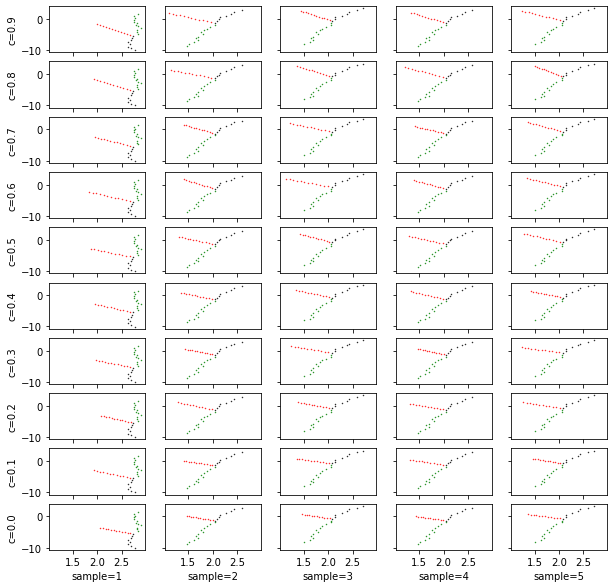

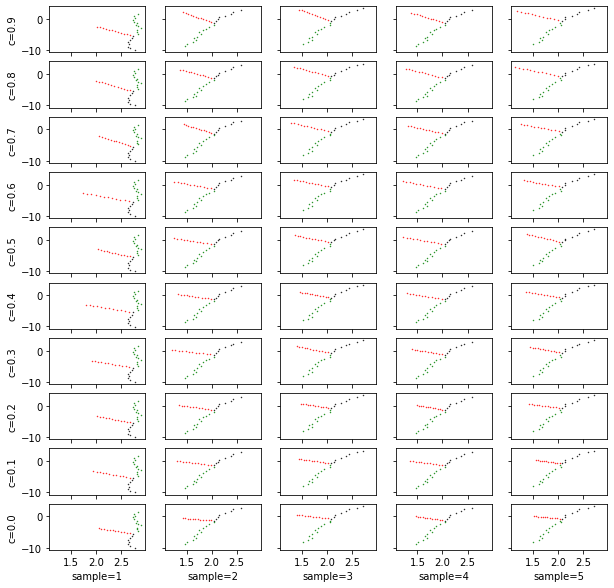

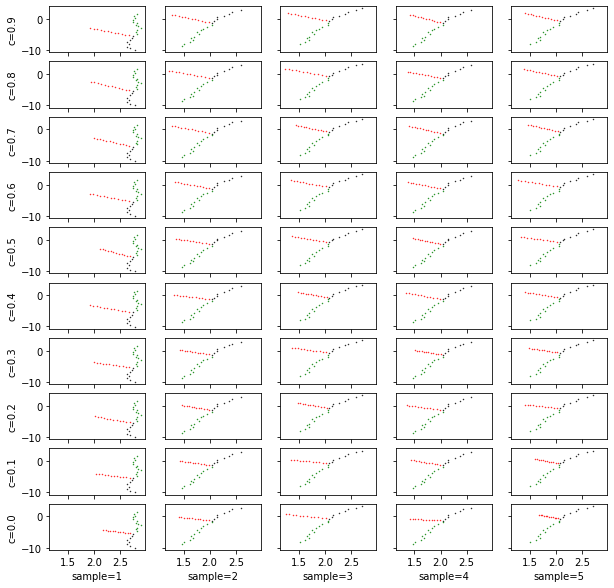

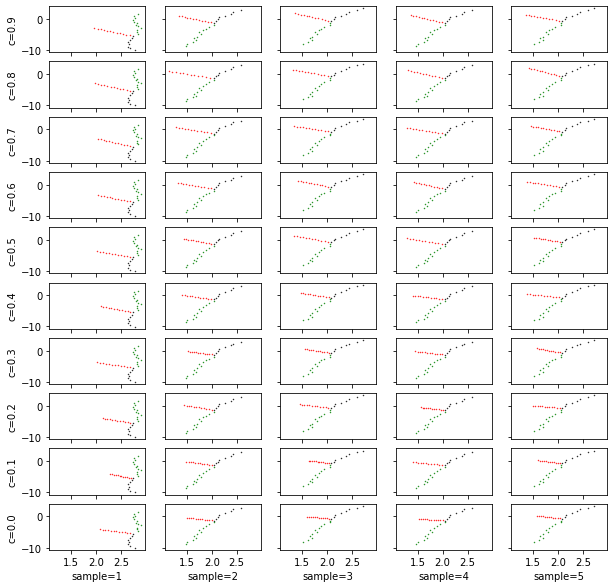

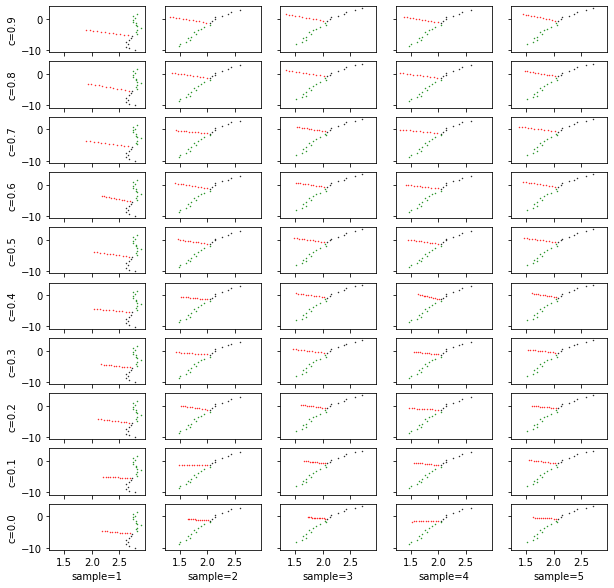

In [27]:
# import wandb
import os
import time
import argparse
import matplotlib.pyplot as plt
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.optim as opt

from tqdm import tqdm, trange
from itertools import chain
from torch.autograd import Variable
from torch.utils.data import DataLoader
# from utils.parse_utils import Scale
# from utils.linear_models import predict_cv

# wandb.init(project='socialways-test')
# config = wandb.config
# config.batch_size = 256
# config.test_batch_size = 256
# config.epochs = 1000
# config.lr = 1E-4
# config.log_interval = 10

# Parser arguments
parser = argparse.ArgumentParser(description='Social Ways trajectory prediction.')
#parser.add_argument('-f', '')
parser.add_argument('--batch-size', '--b',
                    type=int, default=256, metavar='N',
                    help='input batch size for training (default: 256)')
parser.add_argument('--epochs', '--e',
                    type=int, default=100, metavar='N',
                    help='number of epochs to train (default: 1000)')
parser.add_argument('--model', '--m',
                    default='socialWays',
                    choices=['socialWays'],
                    help='pick a specific network to train'
                         '(default: "socialWays")')
parser.add_argument('--latent-dim', '--ld',
                    type=int, default=10, metavar='N',
                    help='dimension of latent space (default: 10)')
parser.add_argument('--d-learning-rate', '--d-lr',
                    type=float, default=1E-3, metavar='N',
                    help='learning rate of discriminator (default: 1E-3)')
parser.add_argument('--g-learning-rate', '--g-lr',
                    type=float, default=1E-4, metavar='N',
                    help='learning rate of generator (default: 1E-4)')
parser.add_argument('--unrolling-steps', '--unroll',
                    type=int, default=1, metavar='N',
                    help='number of steps to unroll gan (default: 1)')
parser.add_argument('--hidden-size', '--h-size',
                    type=int, default=64, metavar='N',
                    help='size of network intermediate layer (default: 64)')
parser.add_argument('--dataset', '--data',
                    default='data-8-12',
                    choices=['data-8-12'],
                    help='pick a specific dataset (default: "hotel")')
#args = parser.parse_args()
args, unknown = parser.parse_known_args()


# ========== set input/output files ============
dataset_name = args.dataset
model_name = args.model
# input_file = '../hotel-8-12.npz'
# input_file = 'traj-datasets/seq_eth/eth-8-12.npz'
# input_file = 'traj-datasets/data_zara01/zara01-8-12.npz'
# input_file = '/content/drive/Othercomputers/My MacBook Pro/projs/socialways/traj-datasets/data_zara01/zara01-8-12.npz'
# model_file = '../trained_models/' + model_name + '-' + dataset_name + '.pt'
# model_file = '/content/drive/Othercomputers/My MacBook Pro/projs/socialways/' + model_name + '-' + dataset_name + '.pt'
# model_file = './' + model_name + '-' + dataset_name + '.pt'
input_file = '../data-8-12.npz'
model_file = 'socialways/' + model_name + '-' + dataset_name + '.pt'
# model_file = '/root/dslteam4/socialways/' + model_name + '-' + dataset_name + '.pt'
# input_file = '/root/dslteam4/socialways/traj-datasets/data_zara02/zara02-8-12.npz'

# FIXME: ====== training hyper-parameters ======
# Unrolled GAN
n_unrolling_steps = args.unrolling_steps
# Info GAN
use_info_loss = True
loss_info_w = 1
n_latent_codes = 2
# L2 GAN
use_l2_loss = False
use_variety_loss = False
loss_l2_w = 0.5  # WARNING for both l2 and variety
# Learning Rate
lr_g = args.g_learning_rate
lr_d = args.d_learning_rate
# FIXME: ====== Network Size ===================
# Batch size
batch_size = args.batch_size
# LSTM hidden size
hidden_size = args.hidden_size
n_epochs = args.epochs
num_social_features = 3
social_feature_size = args.hidden_size
noise_len = args.hidden_size // 2
n_lstm_layers = 1
use_social = False
# ==============================================

# FIXME: ======= Loda Data =====================
# print(os.path.dirname(os.path.realpath(__file__)))

data = np.load(input_file)
# Data come as NxTx2 numpy nd-arrays where N is the number of trajectories,
# T is their duration.
dataset_obsv, dataset_pred, dataset_t, the_batches = \
    data['obsvs'], data['preds'], data['times'], data['batches']
# 4/5 of the batches to be used for training
train_size = max(1, (len(the_batches) * 4) // 5)
train_batches = the_batches[:train_size]
# Test batches are the remaining ones
test_batches = the_batches[train_size:]
# Size of the observed sub-paths
n_past = dataset_obsv.shape[1]
# Size of the sub-paths to predict
n_next = dataset_pred.shape[1]
# Number of training samples
n_train_samples = the_batches[train_size - 1][1]
# Number of testing samples (the remaining ones)
n_test_samples = dataset_obsv.shape[0] - n_train_samples
if n_test_samples == 0:
    n_test_samples = 1
    the_batches = np.array([the_batches[0], the_batches[0]])
print(input_file, ' # Training samples: ', n_train_samples)

# Normalize the spatial data
scale = Scale()
scale.max_x = max(np.max(dataset_obsv[:, :, 0]), np.max(dataset_pred[:, :, 0]))
scale.min_x = min(np.min(dataset_obsv[:, :, 0]), np.min(dataset_pred[:, :, 0]))
scale.max_y = max(np.max(dataset_obsv[:, :, 1]), np.max(dataset_pred[:, :, 1]))
scale.min_y = min(np.min(dataset_obsv[:, :, 1]), np.min(dataset_pred[:, :, 1]))
scale.calc_scale(keep_ratio=True)
dataset_obsv = scale.normalize(dataset_obsv)
dataset_pred = scale.normalize(dataset_pred)
ss = scale.sx
# Copy normalized observations/paths to predict into torch GPU tensors
dataset_obsv = torch.FloatTensor(dataset_obsv).cuda()
dataset_pred = torch.FloatTensor(dataset_pred).cuda()


# ================================================

# Augment tensors of positions into positions+velocity
def get_traj_4d(obsv_p, pred_p):
    obsv_v = obsv_p[:, 1:] - obsv_p[:, :-1]
    # print('obsv_v=', obsv_v)
    obsv_v = torch.cat([obsv_v[:, 0].unsqueeze(1), obsv_v], dim=1)
    obsv_4d = torch.cat([obsv_p, obsv_v], dim=2)
    if len(pred_p) == 0: return obsv_4d
    pred_p_1 = torch.cat([obsv_p[:, -1].unsqueeze(1), pred_p[:, :-1]], dim=1)
    pred_v = pred_p - pred_p_1
    pred_4d = torch.cat([pred_p, pred_v], dim=2)
    return obsv_4d, pred_4d


# Evaluate the error between the model prediction and the true path
def calc_error(pred_hat, pred):
    N = pred.size(0)
    T = pred.size(1)
    err_all = torch.pow((pred_hat - pred) / ss, 2).sum(dim=2).sqrt()  # N x T
    FDEs = err_all.sum(dim=0).item() / N
    ADEs = torch.cumsum(FDEs)
    for ii in range(T):
        ADEs[ii] /= (ii + 1)
    return ADEs.data.cpu().numpy(), FDEs.data().cpu().numpy()


class AttentionPooling(nn.Module):
    def __init__(self, h_dim, f_dim):
        super(AttentionPooling, self).__init__()
        self.f_dim = f_dim
        self.h_dim = h_dim
        self.W = nn.Linear(h_dim, f_dim, bias=True)

    def forward(self, f, h, sub_batches):
        Wh = self.W(h)
        S = torch.zeros_like(h)
        for sb in sub_batches:
            N = sb[1] - sb[0]
            if N == 1: continue

            for ii in range(sb[0], sb[1]):
                fi = f[ii, sb[0]:sb[1]]
                sigma_i = torch.bmm(fi.unsqueeze(1), Wh[sb[0]:sb[1]]. unsqueeze(2))
                sigma_i[ii-sb[0]] = -1000

                attentions = torch.softmax(sigma_i.squeeze(), dim=0)
                S[ii] = torch.mm(attentions.view(1, N), h[sb[0]:sb[1]])

        return S


class EmbedSocialFeatures(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EmbedSocialFeatures, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc = nn.Sequential(nn.Linear(input_size, 32), nn.ReLU(),
                                nn.Linear(32, 64), nn.ReLU(),
                                nn.Linear(64, hidden_size))

    def forward(self, ftr_list, sub_batches):
        embedded_features = self.fc(ftr_list)
        return embedded_features


def DCA(xA_4d, xB_4d):
    dp = xA_4d[:2] - xB_4d[:2]
    dv = xA_4d[2:] - xB_4d[2:]
    ttca = torch.dot(-dp, dv) / (torch.norm(dv) ** 2 + 1E-6)
    # ttca = torch.max(ttca, 0)
    dca = torch.norm(dp + ttca * dv)
    return dca


def Bearing(xA_4d, xB_4d):
    dp = xA_4d[:2] - xB_4d[:2]
    v = xA_4d[2:]
    cos_theta = torch.dot(dp, v) / (torch.norm(dp) * torch.norm(v) + 1E-6)
    return cos_theta


def DCA_MTX(x_4d, D_4d):
    Dp = D_4d[:, :, :2]
    Dv = D_4d[:, :, 2:]
    DOT_Dp_Dv = torch.mul(Dp[:,:,0], Dv[:,:,0]) + torch.mul(Dp[:,:,1], Dv[:,:,1])
    Dv_sq = torch.mul(Dv[:,:,0], Dv[:,:,0]) + torch.mul(Dv[:,:,1], Dv[:,:,1]) + 1E-6
    TTCA = -torch.div(DOT_Dp_Dv, Dv_sq)
    DCA = torch.zeros_like(Dp)
    DCA[:, :, 0] = Dp[:, :, 0] + TTCA * Dv[:, :, 0]
    DCA[:, :, 1] = Dp[:, :, 1] + TTCA * Dv[:, :, 1]
    DCA = torch.norm(DCA, dim=2)
    return DCA


def BearingMTX(x_4d, D_4d):
    Dp = D_4d[:, :, :2]  # NxNx2
    v = x_4d[:, 2:].unsqueeze(1).repeat(1, x_4d.shape[0], 1)  # => NxNx2
    DOT_Dp_v = Dp[:, :, 0] * v[:, :, 0] + Dp[:, :, 1] * v[:, :, 1]
    COS_THETA = torch.div(DOT_Dp_v, torch.norm(Dp, dim=2) * torch.norm(v, dim=2) + 1E-6)
    return COS_THETA


def SocialFeatures(x, sub_batches):
    N = x.shape[0]  # x is NxTx4 tensor

    x_ver_repeat = x[:, -1].unsqueeze(0).repeat(N, 1, 1)
    x_hor_repeat = x[:, -1].unsqueeze(1).repeat(1, N, 1)
    Dx_mat = x_hor_repeat - x_ver_repeat

    l2_dist_MTX = Dx_mat[:, :, :2].norm(dim=2)
    bearings_MTX = BearingMTX(x[:, -1], Dx_mat)
    dcas_MTX = DCA_MTX(x[:, -1], Dx_mat)
    sFeatures_MTX = torch.stack([l2_dist_MTX, bearings_MTX, dcas_MTX], dim=2)

    return sFeatures_MTX   # directly return the Social Features Matrix


# LSTM path encoding module
class EncoderLstm(nn.Module):
    def __init__(self, hidden_size, n_layers=2):
        # Dimension of the hidden state (h)
        self.hidden_size = hidden_size
        super(EncoderLstm, self).__init__()
        # Linear embedding 4xh
        self.embed = nn.Linear(4, self.hidden_size)
        # The LSTM cell.
        # Input dimension (observations mapped through embedding) is the same as the output
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=n_layers, batch_first=True)
        self.lstm_h = []
        # init_weights(self)

    def init_lstm(self, h, c):
        # Initialization of the LSTM: hidden state and cell state
        self.lstm_h = (h, c)

    def forward(self, obsv):
        # Batch size
        bs = obsv.shape[0]
        # Linear embedding
        obsv = self.embed(obsv)
        # Reshape and applies LSTM over a whole sequence or over one single step
        y, self.lstm_h = self.lstm(obsv.view(bs, -1, self.hidden_size), self.lstm_h)
        return y


class Discriminator(nn.Module):
    def __init__(self, n_next, hidden_dim, n_latent_code):
        super(Discriminator, self).__init__()
        self.lstm_dim = hidden_dim
        self.n_next = n_next
        # LSTM Encoder for the observed part
        self.obsv_encoder_lstm = nn.LSTM(4, hidden_dim, batch_first=True)
        # FC sub-network: input is hidden_dim, output is hidden_dim//2. This ouput will be part of
        # the input of the classifier.
        self.obsv_encoder_fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim // 2), nn.LeakyReLU(0.2),
                                             nn.Linear(hidden_dim // 2, hidden_dim // 2))
        # FC Encoder for the predicted part: input is n_next*4 (whole predicted trajectory), output is
        # hidden_dim//2. This ouput will also be part of the input of the classifier.
        self.pred_encoder = nn.Sequential(nn.Linear(n_next * 4, hidden_dim // 2), nn.LeakyReLU(0.2),
                                          nn.Linear(hidden_dim // 2, hidden_dim // 2))
        # Classifier: input is hidden_dim (concatenated encodings of observed and predicted trajectories), output is 1
        self.classifier = nn.Sequential(nn.Linear(hidden_dim, hidden_dim // 2), nn.LeakyReLU(0.2),
                                        nn.Linear(hidden_dim // 2, 1))
        # Latent code inference: input is hidden_dim (concatenated encodings of observed and predicted trajectories), output is n_latent_code (distribution of latent codes)
        self.latent_decoder = nn.Sequential(nn.Linear(hidden_dim, hidden_dim // 2), nn.LeakyReLU(0.2),
                                            nn.Linear(self.lstm_dim // 2, n_latent_code))

    def forward(self, obsv, pred):
        bs = obsv.size(0)
        lstm_h_c = (torch.zeros(1, bs, self.lstm_dim).cuda(),
                    torch.zeros(1, bs, self.lstm_dim).cuda())
        # Encoding of the observed sequence trhough an LSTM cell
        obsv_code, lstm_h_c = self.obsv_encoder_lstm(obsv, lstm_h_c)
        # Further encoding through a FC layer
        obsv_code = self.obsv_encoder_fc(obsv_code[:, -1])
        # Encoding of the predicted/next part of the sequence through a FC layer
        pred_code = self.pred_encoder(pred.view(-1, self.n_next * 4))
        both_codes = torch.cat([obsv_code, pred_code], dim=1)
        # Applies classifier to the concatenation of the encodings of both parts
        label = self.classifier(both_codes)
        # Inference on the latent code
        code_hat = self.latent_decoder(both_codes)
        return label, code_hat

    def load(self, backup):
        for m_from, m_to in zip(backup.modules(), self.modules()):
            if isinstance(m_to, nn.Linear):
                m_to.weight.data = m_from.weight.data.clone()
                if m_to.bias is not None:
                    m_to.bias.data = m_from.bias.data.clone()


# FC path decoding module
class DecoderFC(nn.Module):
    def __init__(self, hidden_dim):
        super(DecoderFC, self).__init__()
        # Fully connected sub-network. Input is hidden_dim, output is 2.
        self.fc1 = torch.nn.Sequential(torch.nn.Linear(hidden_dim, hidden_dim), nn.LeakyReLU(0.2),
                                       # torch.nn.Linear(64, 64), nn.LeakyReLU(0.2),
                                       torch.nn.Linear(hidden_dim, hidden_dim // 2), nn.LeakyReLU(0.2),
                                       torch.nn.Linear(hidden_dim // 2, hidden_dim // 4),
                                       torch.nn.Linear(hidden_dim // 4, 2))

    def forward(self, h, s, z):
        # For each sample in the batch, concatenate h (hidden state), s (social term) and z (noise)
        inp = torch.cat([h, s, z], dim=1)
        # Applies the fully connected layer
        out = self.fc1(inp)
        return out


# LSTM path decoding module
class DecoderLstm(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DecoderLstm, self).__init__()
        # Decoding LSTM
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        # Fully connected sub-network. Input is hidden_size, output is 2.
        self.fc = nn.Sequential(torch.nn.Linear(hidden_size, 64), nn.Sigmoid(),
                                torch.nn.Linear(64, 64), nn.LeakyReLU(0.2),
                                torch.nn.Linear(64, 32), nn.LeakyReLU(0.2),
                                torch.nn.Linear(32, 2))

        # init_weights(self)
        self.lstm_h = []

    def init_lstm(self, h, c):
        # Initialization of the LSTM: hidden state and cell state
        self.lstm_h = (h, c)

    def forward(self, h, s, z):
        # Batch size
        bs = z.shape[0]
        # For each sample in the batch, concatenate h (hidden state), s (social term) and z (noise)
        inp = torch.cat([h, s, z], dim=1)
        # Applies a forward step.
        out, self.lstm_h = self.lstm(inp.unsqueeze(1), self.lstm_h)
        # Applies the fully connected layer to the LSTM output
        out = self.fc(out.squeeze())
        return out


# LSTM-based path encoder
encoder = EncoderLstm(hidden_size, n_lstm_layers).cuda()
feature_embedder = EmbedSocialFeatures(num_social_features, social_feature_size).cuda()
attention = AttentionPooling(hidden_size, social_feature_size).cuda()

# Decoder
decoder = DecoderFC(hidden_size + social_feature_size + noise_len).cuda()
# decoder = DecoderLstm(social_feature_size + VEL_VEC_LEN + noise_len, traj_code_len).cuda()

# The Generator parameters and their optimizer
predictor_params = chain(attention.parameters(), feature_embedder.parameters(),
                         encoder.parameters(), decoder.parameters())
predictor_optimizer = opt.Adam(predictor_params, lr=lr_g, betas=(0.9, 0.999))

# The Discriminator parameters and their optimizer
D = Discriminator(n_next, hidden_size, n_latent_codes).cuda()
D_optimizer = opt.Adam(D.parameters(), lr=lr_d, betas=(0.9, 0.999))
mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss()

print('hidden dim = %d | lr(G) =  %.5f | lr(D) =  %.5f' % (hidden_size, lr_g, lr_d))


def predict(obsv_p, noise, n_next, sub_batches=[]):
    # Batch size
    bs = obsv_p.shape[0]
    # Adds the velocity component to the observations.
    # This makes of obsv_4d a batch_sizexTx4 tensor
    obsv_4d = get_traj_4d(obsv_p, [])
    # Initial values for the hidden and cell states (zero)
    lstm_h_c = (torch.zeros(n_lstm_layers, bs, encoder.hidden_size).cuda(),
                torch.zeros(n_lstm_layers, bs, encoder.hidden_size).cuda())
    encoder.init_lstm(lstm_h_c[0], lstm_h_c[1])
    # Apply the encoder to the observed sequence
    # obsv_4d: batch_sizexTx4 tensor
    encoder(obsv_4d)
    if len(sub_batches) == 0:
        sub_batches = [[0, obsv_p.size(0)]]

    if use_social:
        features = SocialFeatures(obsv_4d, sub_batches)
        emb_features = feature_embedder(features, sub_batches)
        weighted_features = attention(emb_features, encoder.lstm_h[0].squeeze(), sub_batches)
    else:
        weighted_features = torch.zeros_like(encoder.lstm_h[0].squeeze())

    pred_4ds = []
    last_obsv = obsv_4d[:, -1]
    # For all the steps to predict, applies a step of the decoder
    for ii in range(n_next):
        # Takes the current output of the encoder to feed the decoder
        # Gets the ouputs as a displacement/velocity
        new_v = decoder(encoder.lstm_h[0].view(bs, -1), weighted_features.view(bs, -1), noise).view(bs, 2)
        # Deduces the predicted position
        new_p = new_v + last_obsv[:, :2]
        # The last prediction done will be new_p,new_v
        last_obsv = torch.cat([new_p, new_v], dim=1)
        # Keeps all the predictions
        pred_4ds.append(last_obsv)
        # Applies LSTM encoding to the last prediction
        # pred_4ds[-1]: batch_sizex4 tensor
        encoder(pred_4ds[-1])

    return torch.stack(pred_4ds, 1)


# ===================================================

print('Loading model from ' + model_file)
checkpoint = torch.load(model_file)
start_epoch = checkpoint['epoch'] + 1

attention.load_state_dict(checkpoint['attentioner_dict'])
feature_embedder.load_state_dict(checkpoint['feature_embedder_dict'])
encoder.load_state_dict(checkpoint['encoder_dict'])
decoder.load_state_dict(checkpoint['decoder_dict'])
predictor_optimizer.load_state_dict(checkpoint['pred_optimizer'])

D.load_state_dict(checkpoint['D_dict'])
D_optimizer.load_state_dict(checkpoint['D_optimizer'])

# =======================================================
# ===================== M A I N =========================
# =======================================================
code_infer_samples_num = 5
def code_infer(n_gen_samples=20, linear=False, write_to_file=None, just_one=False):
    plt.close()
    a, b = test_batches.shape
    samples_idces = np.random.choice(a, code_infer_samples_num*200)
    samples = test_batches[samples_idces, :]
    filter_samples = np.ndarray(shape=(5,2), dtype=int, order='F')
    cnt = 0
    for jj, batch_j in enumerate(samples):
#         print('jj', jj, ', batch_j', type(batch_j))
        obsv = dataset_obsv[batch_j[0]:batch_j[1]]
        pred = dataset_pred[batch_j[0]:batch_j[1]]
        print('obsv', obsv[0])
#         print('pred', pred[0][:][0:8])
        sub = torch.sub(obsv, pred[0][:][0:8])
    
        if(abs(obsv[0][0][0].item() - obsv[0][2][0].item()) <= 0.01):
            continue
        mean_val = torch.mean(sub, dim=[0,1,2], keepdim=True)
        print('obsv', obsv[0])
        print('pred', pred[0][:][0:8])
        if(abs(mean_val[0][0][0].item()) <= 0.01):
            continue
        else:
#             print('In else, mean=', abs(mean_val[0][0][0].item()) <= 0.01)
            filter_samples[cnt]= batch_j
            if cnt == 4:
                break
            cnt += 1
#     print('cnt=', cnt)
    print('filter_samples', filter_samples)
    code_traverse(0, 1, write_to_file, filter_samples)
#     code_traverse(1, 0, write_to_file, filter_samples)

def code_traverse(fix_code_idx, vary_code_idx, write_to_file, samples):
    fix_code_agent = 0

    while fix_code_agent < 10:
        name_arr = [0, 0]
        name_arr[fix_code_idx] = str(fix_code_agent)
        name_arr[vary_code_idx] = 'X'

        img_path = write_to_file + "/" + "_".join(name_arr)
        fig, axe = plt.subplots(10, code_infer_samples_num, sharex=True, sharey=True, figsize=(10, 10))
        for jj, batch_j in enumerate(samples):
            print('jj=', jj, ', batch_j=', batch_j)
            obsv = dataset_obsv[batch_j[0]:batch_j[1]]
            pred = dataset_pred[batch_j[0]:batch_j[1]]
            print('obsv=', obsv, ', grd=', pred)
            bs = int(batch_j[1] - batch_j[0])
            with torch.no_grad():
                # cannot use float in a loop
                vary_code_agent = 0
                while vary_code_agent < 10:
                    noise = torch.FloatTensor(torch.rand(bs, noise_len)).cuda()
                    for b_idx in range(bs):
                        noise[b_idx][vary_code_idx] = vary_code_agent / 10
                        noise[b_idx][fix_code_idx] = fix_code_agent / 10
                    pred_hat_4d = predict(obsv, noise, n_next)
                    obsv_dn = scale.denormalize(obsv[0].data.cpu().numpy())
                    pred_dn = scale.denormalize(pred[0].data.cpu().numpy())
                    pred_hat_2d_dn = scale.denormalize(pred_hat_4d[0][:][:, [0, 1]].data.cpu().numpy())
#                     obsv_dn = obsv[0].data.cpu().numpy()
#                     pred_dn = pred[0].data.cpu().numpy()
#                     pred_hat_2d_dn = pred_hat_4d[0][:][:, [0, 1]].data.cpu().numpy()
                    # pred_hat_2d_dn = pred_hat_4d[0][:][:, [0, 2]].data.cpu().numpy()

                    print('obsv before=', obsv[0], ', grd before=', pred[0], ', pred_hat before',
                          pred_hat_4d[0][:][:, [0, 1]])
#                     print('pred_hat_2d_dn=', pred_hat_2d_dn)
                    print('obsv=', obsv_dn, 'grd=', pred_dn, 'pred=', pred_hat_2d_dn)

                    x_obsv, y_obsv = zip(*obsv_dn)
                    x_pred, y_pred = zip(*pred_dn)
                    x_pred_hat, y_pred_hat = zip(*pred_hat_2d_dn)
                    fig_idx = vary_code_agent
                    current_axe = axe[fig_idx, jj]
                    # print("axe coor=(", fig_idx, ',', jj , ')')
                    current_axe.scatter(x_obsv, y_obsv, c='black', s=0.2, marker='o')
                    current_axe.scatter(x_pred, y_pred, c='green', s=0.2, marker='o')
                    current_axe.scatter(x_pred_hat, y_pred_hat, c='red', s=0.2, marker='o')
                    # current_axe.set(ylabel='code=' + str(vary_code_agent / 10) + '')
                    vary_code_agent = vary_code_agent + 1
            for k in range(10):
                axe0 = axe[k, 0]
                axe0.set(ylabel='c=' + str((9 - k) / 10))
            for i1 in range(10):
                for j1 in range(code_infer_samples_num):
                    axe1 = axe[9, j1]
                    axe1.set(xlabel='sample=' + str(j1 + 1) + '')
            img_name = img_path + '.png'
            print(img_name)
#             plt.show()
            plt.savefig(img_name)
            # wandb.save(img_name, base_path="./traj-figs/" + dataset_name)
        fix_code_agent += 2

# # FIXME: comment here to train
# wr_dir = '/content/drive/Othercomputers/My MacBook Pro/projs/socialways/preds-iccv/' + dataset_name + '/' + model_name + '/' + str(0000)
wr_dir = 'socialways/preds-iccv/' + dataset_name + '/' + model_name + '/' + str(0000)
# wr_dir = '/root/dslteam4/socialways/preds-iccv/' + dataset_name + '/' + model_name + '/' + str(0000)
os.makedirs(wr_dir, exist_ok=True)
# test(n_gen_samples=128, write_to_file=wr_dir, just_one=False)
code_infer(n_gen_samples=128, write_to_file=wr_dir)
exit(1)